# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook
from IPython.display import display
import time

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC, LinearSVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

SEED = 24

# Load data

In [2]:
# load data
df = pd.read_csv('data/weather.csv')
df.sort_values(by=['Location_ID', 'Date'], inplace=True)
df.reset_index(inplace=True);

print(df.shape)
df.head(3).T

(142193, 29)


0           1           2
index               32041       32042       32043
Unnamed: 0          32041       32042       32043
Date           2008-07-01  2008-07-02  2008-07-03
Location_ID             0           0           0
Location         Adelaide    Adelaide    Adelaide
Cloud9am              NaN         NaN         NaN
Cloud3pm              NaN         NaN         NaN
Humidity9am            92          75          81
Humidity3pm            67          52          56
Pressure9am        1017.4      1022.4      1027.8
Pressure3pm        1017.7      1022.6      1026.5
RISK_MM               0.8           0           0
RainTomorrow        False       False       False
MinTemp               8.8        12.7         6.2
MaxTemp              15.7        15.8        15.1
Temp9am              13.5        13.7         9.3
Temp3pm              14.9        15.5        13.9
Rainfall                5         0.8           0
Evaporation           1.6         1.4         1.8
Sunshine              2.6         7.8         2.1
RainToday            True       False       False
WindGustDir            NW          SW           W
WindGustSpeed          48          35          20
WindDir9am             SW         SSW         NNE
WindDir3pm              W          SW          SW
WindSpeed9am           13          13           2
WindSpeed3pm           15          15          11
Data2          2008-07-01  2008-07-02  2008-07-03
Location_ID2            0           0           0

# Cleaning and preparing PANDAS

In [34]:
# separate target
df_target = df['RainTomorrow'].map(lambda x: 1 if x == True else 0).astype('uint8')
# load data

# convert dates
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df['year'] = df['Date'].dt.year.astype('uint16')
df['month'] = df['Date'].dt.month.astype('uint8')

df['season'] = df['month'].apply(lambda x: 1 if x in [1,11,12] else 
                                2 if x in [3, 4, 5] else 
                                3 if x in [6, 7, 8] else 4).astype('uint8')


# drop
# Drop RISK_MM, RainTomorrow, Location, Date
df.drop(['Unnamed: 0', 'Data2',  'Location', 'Location_ID2', 'RISK_MM', 'RainTomorrow', 'RainToday', 'index'], axis=1, inplace=True)
print(df.shape, df.duplicated().sum(), df.columns)

# df.dtypes
df_befor = df.copy()

(142193, 24) 0 Index(['Date', 'Location_ID', 'Cloud9am', 'Cloud3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'MinTemp', 'MaxTemp',
       'Temp9am', 'Temp3pm', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'year', 'month', 'season'],
      dtype='object')


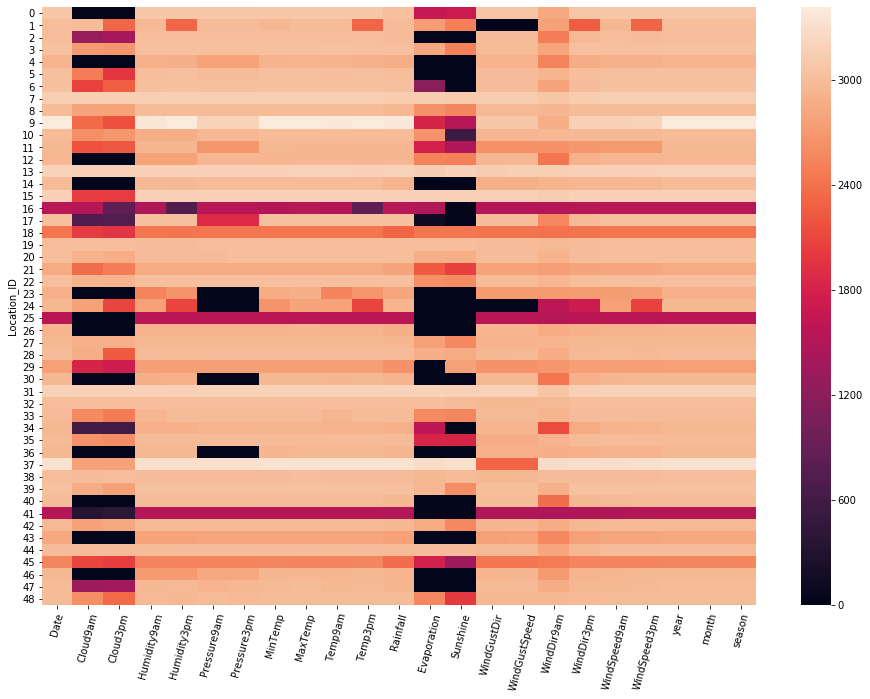

In [35]:
plt.figure(figsize=(16,11))
sns.heatmap(df.groupby(by='Location_ID').count());
plt.xticks(rotation=75);

# Preprocessing Pipeline Befor split on train, test

In [36]:
# change Rainfall with 0 if no records
df['Rainfall'].fillna(0, inplace=True)
df['Rainfall'].isna().sum()

0

In [37]:
class fill_from_other_column(BaseEstimator, TransformerMixin):
    """
    Fill column1 if is nan, from column2
    """
    def __init__(self, column1, column2, df): # , df_new=None):
        self.column1 = column1
        self.column2 = column2
        self.df = df[[column1, column2]]
        
    def fit(self, X=None, y=None):
        return self
    
    def transform(self, X=None):
        temp = self.df
        temp[self.column1] = temp.apply(lambda row: row[self.column1] if pd.notna(row[self.column1]) else row[self.column2], axis=1)
        return temp[self.column1]
    
# this comment for test class
# temp = df[['Date', 'Location_ID','Humidity9am', 'Humidity3pm']]
# print(temp['Humidity9am'].isna().sum())
# tr = fill_from_other_column(column1='Humidity9am', column2='Humidity3pm', df=temp)
# temp.loc[:,['Humidity9am']] = tr.fit_transform(None)
# print(temp['Humidity9am'].isna().sum())

class fill_from_this_column_by_group(BaseEstimator, TransformerMixin):
    """
    Fill column in current groups
    """
    def __init__(self, by, order, column, df, df_new=None, interpolate=True):
        self._last_row = 10
        self.by = by
        self.order = order
        self.column = column
        self.df = df[[by, order, column]]
        self.df_new = df_new
        self.interpolate = interpolate
        
    def fit(self, X=None, y=None):
        return self
    
    def transform(self, X=None):
        
        if self.df_new != None:
            # append to end main df (take some tail(10) rows)
            self.df = self.df.tail(self._last_row)
            self.df = pd.concat([self.df, self.df_new[[[self.by, self.order, self.column]]]], axis=0)
        temp = self.df
        # Define helper function
        _col_index_history = 'index_history'

        def fill_missing(grp):
            grp[_col_index_history] = grp.index
            grp['Date_temp'] = grp[self.order]
            if self.interpolate:
                res = grp.set_index('Date_temp')\
                .interpolate(method='linear',limit=5)\
                .fillna(method='ffill')\
                .fillna(method='bfill')
            else:
                res = grp.set_index('Date_temp')\
                .fillna(method='ffill')\
                .fillna(method='bfill')
                
            return res

        # Group by smth and fill missing
        temp = temp.groupby([self.by]).apply(lambda grp: fill_missing(grp)).\
                                set_index(_col_index_history, drop=True)
        return temp[self.column]

# this comment for test class
# tr2 = fill_from_this_column_by_group(by='Location_ID', order='Date', column='Humidity9am', df=temp, df_new=None)
# temp.loc[:,['Humidity9am']] = tr2.fit_transform(None)
# print(temp['Humidity9am'].isna().sum())

In [38]:
paired_columns = [
    ('Humidity9am', 'Humidity3pm'),
    ('Humidity3pm', 'Humidity9am'),
    ('Temp9am', 'Temp3pm'),
    ('Temp3pm', 'Temp9am'),
    ('MinTemp', 'Temp9am'),
    ('MaxTemp', 'Temp3pm'),
    ('WindSpeed9am', 'WindSpeed3pm'),
    ('WindSpeed3pm', 'WindSpeed9am'),
    ('WindGustSpeed', 'WindSpeed3pm'),
]
for col1, col2 in paired_columns:
    print(df[col1].isna().sum(), end=' ')
for col1, col2 in tqdm_notebook(paired_columns, desc='tqdm'):
    if df[col1].isna().sum() ==0:
        continue
    tr = fill_from_other_column(column1=col1, column2=col2, df=df)
    df[col1] = tr.fit_transform(None)
    tr2 = fill_from_this_column_by_group(by='Location_ID', order='Date', column=col1, df=df)
    df[col1] = tr2.fit_transform(None)

for col1, col2 in paired_columns:
    print(df[col1].isna().sum(), end=' ')


1774 3610 904 2726 637 322 1348 2630 9270 

C:\Users\makag\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app



0 0 0 0 0 0 0 0 0 

In [39]:
# отдельно для категориальных Direction без интерполяции
paired_columns = [
    ('WindDir9am', 'WindDir3pm'),
    ('WindDir3pm', 'WindDir9am'),
    ('WindGustDir', 'WindDir3pm'), # average speed at 3pm more then 9am on 4km/h
]
for col1, col2 in paired_columns:
    print(df[col1].isna().sum(), end=' ')
    
for col1, col2 in tqdm_notebook(paired_columns, desc='tqdm'):
    if df[col1].isna().sum() ==0:
        continue
    tr = fill_from_other_column(column1=col1, column2=col2, df=df)
    df[col1] = tr.fit_transform(None)
    tr2 = fill_from_this_column_by_group(by='Location_ID', order='Date', column=col1, df=df, interpolate=False)
    df[col1] = tr2.fit_transform(None)

for col1, col2 in paired_columns:
    print(df[col1].isna().sum(), end=' ')

10013 3778 9330 

C:\Users\makag\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app



0 0 0 

In [40]:
# выборочно по Location заполнить Pressure, Cloud, Evaporation, Sunshine
# Pressure
exeption_locations_pressure = [4, 11, 17, 23, 24, 30, 36]
mask = ~(df['Location_ID'].isin(exeption_locations_pressure))
# mask = (df['Location_ID'] == 4)
paired_columns = [
    ('Pressure9am', 'Pressure3pm'),
    ('Pressure3pm', 'Pressure9am'),
]

for col1, col2 in paired_columns:
    print(df[col1][mask].isna().sum(), end=' ')
    
for col1, col2 in tqdm_notebook(paired_columns, desc='tqdm'):
    if df[col1][mask].isna().sum() ==0:
        continue
    tr = fill_from_other_column(column1=col1, column2=col2, df=df[mask])
    df[col1][mask] = tr.fit_transform(None)
    tr2 = fill_from_this_column_by_group(by='Location_ID', order='Date', column=col1, df=df[mask])
    df[col1][mask] = tr2.fit_transform(None)

for col1, col2 in paired_columns:
    print(df[col1][mask].isna().sum(), end=' ')

679 640 

C:\Users\makag\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\makag\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0 0 

In [41]:
# выборочно по Location заполнить Pressure, Cloud, Evaporation, Sunshine
# Cloud (всего десять значений, без интерполяции)
exeption_locations_cloud = [ 0, 4, 9, 11, 12, 14, 15, 17, 18, 23, 25, 26, 30, 34, 36, 37, 40, 41, 43, 46 ]
mask = ~(df['Location_ID'].isin(exeption_locations_cloud))
paired_columns = [
    ('Cloud9am', 'Cloud3pm'),
    ('Cloud3pm', 'Cloud9am'),
]

for col1, col2 in paired_columns:
    print(df[col1][mask].isna().sum(), end=' ')
    
for col1, col2 in tqdm_notebook(paired_columns, desc='tqdm'):
    if df[col1][mask].isna().sum() ==0:
        continue
    tr = fill_from_other_column(column1=col1, column2=col2, df=df[mask])
    df[col1][mask] = tr.fit_transform(None)
    tr2 = fill_from_this_column_by_group(by='Location_ID', order='Date', column=col1, df=df[mask], interpolate=False)
    df[col1][mask] = tr2.fit_transform(None)

for col1, col2 in paired_columns:
    print(df[col1][mask].isna().sum(), end=' ')

9818 13104 

C:\Users\makag\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\makag\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0 0 

In [42]:
# выборочно по Location заполнить Pressure, Cloud, Evaporation, Sunshine
# Evaporation
exeption_locations_evaporation = [0, 2, 4, 5, 6, 8, 9, 10, 11, 12, 14, 17, 18, 21,\
        22, 23, 24, 25, 26, 29, 30, 33, 34, 35, 36, 40, 41, 43, 45, 46, 47]
mask = ~(df['Location_ID'].isin(exeption_locations_evaporation))
# mask = (df['Location_ID'] == 10)
paired_columns = [ ('Evaporation', None) ]

for col1, col2 in paired_columns:
    print(df[col1][mask].isna().sum(), end=' ')
    
for col1, col2 in tqdm_notebook(paired_columns, desc='tqdm'):
    if df[col1][mask].isna().sum() ==0:
        continue
    tr2 = fill_from_this_column_by_group(by='Location_ID', order='Date', column=col1, df=df[mask])
    df[col1][mask] = tr2.fit_transform(None)

for col1, col2 in paired_columns:
    print(df[col1][mask].isna().sum(), end=' ')

1847 

C:\Users\makag\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()



0 

In [43]:
# выборочно по Location заполнить Pressure, Cloud, Evaporation, Sunshine
# Sunshine
exeption_locations_sunshine = [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 16, \
        17, 18, 21, 22, 23, 24, 25, 26, 27, 30, 33, 34, 35, 36, 39, 40, 41, 42, 43, 45, 46, 47, 48]
mask = ~(df['Location_ID'].isin(exeption_locations_sunshine))
# mask = (df['Location_ID'] == 10)
paired_columns = [ ('Sunshine', None) ]

for col1, col2 in paired_columns:
    print(df[col1][mask].isna().sum(), end=' ')
    
for col1, col2 in tqdm_notebook(paired_columns, desc='tqdm'):
    if df[col1][mask].isna().sum() ==0:
        continue
    tr2 = fill_from_this_column_by_group(by='Location_ID', order='Date', column=col1, df=df[mask])
    df[col1][mask] = tr2.fit_transform(None)

for col1, col2 in paired_columns:
    print(df[col1][mask].isna().sum(), end=' ')

403 

C:\Users\makag\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()



0 

In [44]:
# replace wind directions with numeric
wind_rose = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
dict_replacer = dict(zip(wind_rose, range(len(wind_rose))))
df.replace(dict_replacer, inplace=True)
# df[['WindGustDir', 'WindDir9am', 'WindDir3pm']].isna().sum()

In [45]:
df.head(2).T

0                    1
Date           2008-07-01 00:00:00  2008-07-02 00:00:00
Location_ID                      0                    0
Cloud9am                       NaN                  NaN
Cloud3pm                       NaN                  NaN
Humidity9am                     92                   75
Humidity3pm                     67                   52
Pressure9am                 1017.4               1022.4
Pressure3pm                 1017.7               1022.6
MinTemp                        8.8                 12.7
MaxTemp                       15.7                 15.8
Temp9am                       13.5                 13.7
Temp3pm                       14.9                 15.5
Rainfall                         5                  0.8
Evaporation                    1.6                  1.4
Sunshine                       2.6                  7.8
WindGustDir                     14                   10
WindGustSpeed                   48                   35
WindDir9am                      10                    9
WindDir3pm                      12                   10
WindSpeed9am                    13                   13
WindSpeed3pm                    15                   15
year                          2008                 2008
month                            7                    7
season                           3                    3

In [46]:
df_first_step = df.copy()

In [50]:
print(df_first_step.shape, df_target.shape)
df_first_step = pd.concat([df_first_step, df_target], axis=1)
df_first_step.to_csv('data/df_after_first_step_imputations.csv')
print(df_first_step.shape)
df_first_step.drop(['RainTomorrow'], axis=1, inplace=True)
# df = df_first_step.copy()
print(df_first_step.shape, df.shape)

(142193, 24) (142193,)
(142193, 25)
(142193, 24) (142193, 24)


In [54]:
df.shape
# df.head(2).T

(142193, 24)

# Piplines to predict feature with a lot of missing values 

In [55]:
# order for predict. with eacn next predict we use more and more fetures
list_for_fill = ['Pressure9am', 'Pressure3pm', 'Evaporation', 'Cloud9am', 'Cloud3pm', 'Sunshine']
all_col = list(set(df.columns.to_list()) - set(['Date']))
for i, curent_predict_col in enumerate(list_for_fill[:]):
    print(df[curent_predict_col].isna().sum())
    exeption_col_for_predict = list_for_fill[i:]
    cur_col = list(set(all_col) - set(exeption_col_for_predict))
    print(len(cur_col))
    check_for_next_step = df[cur_col].isna().sum().sum()
    if check_for_next_step == 0:
        print(f'All data prepear to predict {curent_predict_col}')
    else:
        print(f'Still have missing values {check_for_next_step}')
    mask_is_nan = df[curent_predict_col].isna()
    mask_is_not_nan = ~mask_is_nan
    # split on train and test to predict nan value
    df_train = df[cur_col][mask_is_not_nan].copy()
    target = df[curent_predict_col][mask_is_not_nan]
    df_test = df[cur_col][mask_is_nan].copy()
    print(f'Column: {curent_predict_col}  train:{df_train.shape} test:{df_test.shape} y:{target.shape} split_size: {len(df_test)/len(df)*100:.1f}%')
    display(df_train.head(2))
    scale = StandardScaler()
    pca = PCA(0.99)
    cv = KFold(shuffle=False, n_splits=2, random_state=SEED)
    SVR = LinearSVR()
    pipe = Pipeline([
        ('scale', scale),
#         ('pca', pca),
        ('svr', SVR)
           ])
    param_distributions = {
        'svr__C': [0.1, 1., 3., 5., 8.],
    }
    grid = RandomizedSearchCV(
        estimator=pipe, 
        param_distributions=param_distributions,
        n_jobs=-1, 
        cv=cv, 
        verbose=0, 
        scoring='neg_mean_squared_error',
        random_state=SEED,
        return_train_score=True,
    )
    start = time.time()
    
    grid.fit(df_train, target)
    
    end = time.time()
    
    print(f'It lasted for {round(end - start, 3)} sec')
    
    print(grid.best_params_)
    pred_train = grid.best_estimator_.predict(df_train)
    pred_mean = np.full_like(pred_train, target.mean())
    print(pred_mean.shape, pred_mean)
    print(f'R2 {r2_score(target, pred_train)} ...R2 mean {r2_score(target, pred_mean)}') 
    print(f'MSE {mean_squared_error(target, pred_train)}') 
    print(f'RMSE {np.sqrt(mean_squared_error(target, pred_train))}') 
    print(target.min(), target.max(),  target.mean(), target.std())
    
    empty_test = df[curent_predict_col][mask_is_nan]
    df[curent_predict_col][mask_is_nan] = grid.best_estimator_.predict(df_test)
    empty_test2 = df[curent_predict_col][mask_is_nan]
    
#     break
df.isna().sum().sum()

13335
17
All data prepear to predict Pressure9am
Column: Pressure9am  train:(128858, 17) test:(13335, 17) y:(128858,) split_size: 9.4%


Location_ID  WindSpeed9am  Temp3pm  MinTemp  Rainfall  WindSpeed3pm  \
0            0          13.0     14.9      8.8       5.0          15.0   
1            0          13.0     15.5     12.7       0.8          15.0   

   season  month  WindDir9am  year  Humidity3pm  WindGustDir  WindGustSpeed  \
0       3      7          10  2008         67.0           14           48.0   
1       3      7           9  2008         52.0           10           35.0   

   MaxTemp  WindDir3pm  Humidity9am  Temp9am  
0     15.7          12         92.0     13.5  
1     15.8          10         75.0     13.7

C:\Users\makag\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
C:\Users\makag\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


It lasted for 47.861 sec
{'svr__C': 0.1}
(128858,) [1017.65095156 1017.65095156 1017.65095156 ... 1017.65095156 1017.65095156
 1017.65095156]
R2 0.40938293564385797 ...R2 mean -2.220446049250313e-16
MSE 29.752961529421164
RMSE 5.45462753351878
980.5 1041.0 1017.6509515555925 7.097637099687705


C:\Users\makag\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


13341
18
All data prepear to predict Pressure3pm
Column: Pressure3pm  train:(128852, 18) test:(13341, 18) y:(128852,) split_size: 9.4%


Location_ID  WindSpeed9am  Temp3pm  MinTemp  Rainfall  WindSpeed3pm  \
0            0          13.0     14.9      8.8       5.0          15.0   
1            0          13.0     15.5     12.7       0.8          15.0   

   season  month  WindDir9am  year  Humidity3pm  WindGustDir  Pressure9am  \
0       3      7          10  2008         67.0           14       1017.4   
1       3      7           9  2008         52.0           10       1022.4   

   WindGustSpeed  MaxTemp  WindDir3pm  Humidity9am  Temp9am  
0           48.0     15.7          12         92.0     13.5  
1           35.0     15.8          10         75.0     13.7

C:\Users\makag\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
C:\Users\makag\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


It lasted for 92.395 sec
{'svr__C': 1.0}
(128852,) [1015.26958377 1015.26958377 1015.26958377 ... 1015.26958377 1015.26958377
 1015.26958377]
R2 0.9491695863656802 ...R2 mean 0.0
MSE 2.5130879311731715
RMSE 1.5852721946634816
977.1 1039.6 1015.2695837670348 7.031430777465649


C:\Users\makag\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


58996
19
All data prepear to predict Evaporation
Column: Evaporation  train:(83197, 19) test:(58996, 19) y:(83197,) split_size: 41.5%


Location_ID  Temp3pm  Rainfall  Pressure3pm  season  month  year  \
0            0     14.9       5.0       1017.7       3      7  2008   
1            0     15.5       0.8       1022.6       3      7  2008   

   Pressure9am  WindGustSpeed  MaxTemp  Humidity9am  WindDir3pm  WindSpeed9am  \
0       1017.4           48.0     15.7         92.0          12          13.0   
1       1022.4           35.0     15.8         75.0          10          13.0   

   MinTemp  WindDir9am  WindGustDir  Humidity3pm  WindSpeed3pm  Temp9am  
0      8.8          10           14         67.0          15.0     13.5  
1     12.7           9           10         52.0          15.0     13.7

C:\Users\makag\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
C:\Users\makag\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
C:\Users\makag\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


It lasted for 62.488 sec
{'svr__C': 3.0}
(83197,) [5.57773147 5.57773147 5.57773147 ... 5.57773147 5.57773147 5.57773147]
R2 0.4143487304395471 ...R2 mean 0.0
MSE 11.569960675925628
RMSE 3.40146448988162
0.0 145.0 5.577731469734868 4.444767074538081


C:\Users\makag\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


43839
20
All data prepear to predict Cloud9am
Column: Cloud9am  train:(98354, 20) test:(43839, 20) y:(98354,) split_size: 30.8%


Location_ID  Temp3pm  Rainfall  Pressure3pm  season  month  year  \
3090            1     17.9       0.0       1015.2       1     12  2008   
3091            1     19.1       0.0       1009.3       1     12  2008   

      Pressure9am  WindGustSpeed  MaxTemp  Humidity9am  WindDir3pm  \
3090       1017.9           17.0     18.5         82.0          10   
3091       1012.8           17.0     21.0         64.0           5   

      Evaporation  WindSpeed9am  MinTemp  WindDir9am  WindGustDir  \
3090          3.8           4.0     13.3          15           10   
3091          5.4           6.0     14.7           2            5   

      Humidity3pm  WindSpeed3pm  Temp9am  
3090         63.0          17.0     15.2  
3091         71.0          17.0     17.8

C:\Users\makag\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
C:\Users\makag\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
C:\Users\makag\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


It lasted for 74.482 sec
{'svr__C': 8.0}
(98354,) [4.45282347 4.45282347 4.45282347 ... 4.45282347 4.45282347 4.45282347]
R2 0.2990322053394461 ...R2 mean 0.0
MSE 5.864410865077632
RMSE 2.421654571791285
0.0 9.0 4.452823474388434 2.89244673515029


C:\Users\makag\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


43990
21
All data prepear to predict Cloud3pm
Column: Cloud3pm  train:(98203, 21) test:(43990, 21) y:(98203,) split_size: 30.9%


Location_ID  Temp3pm  Rainfall  Pressure3pm  season  month  year  \
3090            1     17.9       0.0       1015.2       1     12  2008   
3091            1     19.1       0.0       1009.3       1     12  2008   

      Pressure9am  WindGustSpeed  MaxTemp  ...  WindDir3pm  Evaporation  \
3090       1017.9           17.0     18.5  ...          10          3.8   
3091       1012.8           17.0     21.0  ...           5          5.4   

      WindSpeed9am  MinTemp  WindDir9am  WindGustDir  Humidity3pm  Cloud9am  \
3090           4.0     13.3          15           10         63.0       7.0   
3091           6.0     14.7           2            5         71.0       2.0   

      WindSpeed3pm  Temp9am  
3090          17.0     15.2  
3091          17.0     17.8  

[2 rows x 21 columns]

C:\Users\makag\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
C:\Users\makag\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
C:\Users\makag\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


It lasted for 82.052 sec
{'svr__C': 8.0}
(98203,) [4.49788703 4.49788703 4.49788703 ... 4.49788703 4.49788703 4.49788703]
R2 0.3806641243107164 ...R2 mean 0.0
MSE 4.712158900710743
RMSE 2.170750768907095
0.0 9.0 4.497887029927803 2.7583479932100867


C:\Users\makag\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


67413
22
All data prepear to predict Sunshine
Column: Sunshine  train:(74780, 22) test:(67413, 22) y:(74780,) split_size: 47.4%


Location_ID  Temp3pm  Rainfall  Pressure3pm  season  month  year  \
0            0     14.9       5.0       1017.7       3      7  2008   
1            0     15.5       0.8       1022.6       3      7  2008   

   Pressure9am  WindGustSpeed  MaxTemp  ...  Evaporation  WindSpeed9am  \
0       1017.4           48.0     15.7  ...          1.6          13.0   
1       1022.4           35.0     15.8  ...          1.4          13.0   

   MinTemp  WindDir9am  Cloud3pm  WindGustDir  Humidity3pm  Cloud9am  \
0      8.8          10  6.731560           14         67.0  6.444430   
1     12.7           9  6.426017           10         52.0  6.487496   

   WindSpeed3pm  Temp9am  
0          15.0     13.5  
1          15.0     13.7  

[2 rows x 22 columns]

C:\Users\makag\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
C:\Users\makag\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
C:\Users\makag\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


It lasted for 60.855 sec
{'svr__C': 8.0}
(74780,) [7.62587866 7.62587866 7.62587866 ... 7.62587866 7.62587866 7.62587866]
R2 0.6582208257705653 ...R2 mean 2.220446049250313e-16
MSE 4.87823613898534
RMSE 2.208672936173516
0.0 14.5 7.625878663994462 3.7779961878917203


C:\Users\makag\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0

In [56]:
df_after_all_imputations = df.copy()
print(df_after_all_imputations.shape, df_target.shape)
df_after_all_imputations = pd.concat([df_after_all_imputations, df_target], axis=1)
df_after_all_imputations.to_csv('data/df_after_all_imputations.csv')
print(df_after_all_imputations.shape)
df_after_all_imputations.drop(['RainTomorrow'], axis=1, inplace=True)
# df = df_first_step.copy()
print(df_after_all_imputations.shape, df.shape)

(142193, 24) (142193,)
(142193, 25)
(142193, 24) (142193, 24)


# Plot some features in time (filtering on Location_ID) to compare befor and after filling missing values

C:\Users\makag\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
C:\Users\makag\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


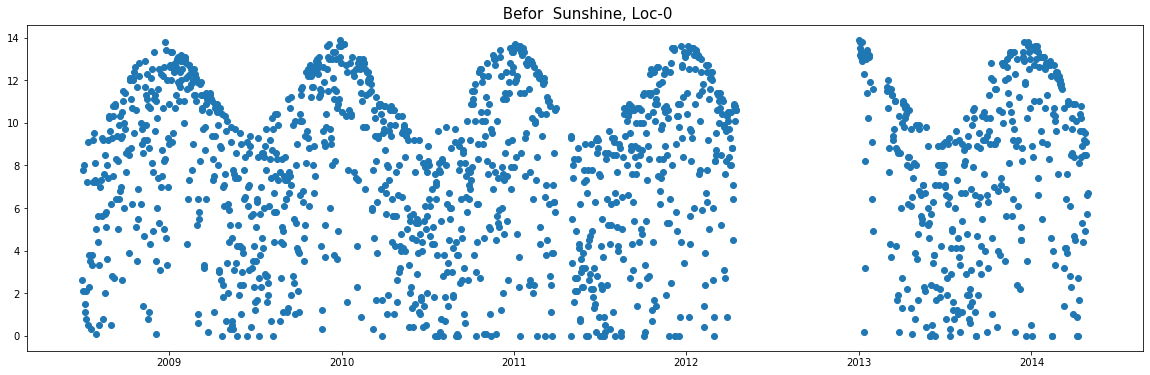

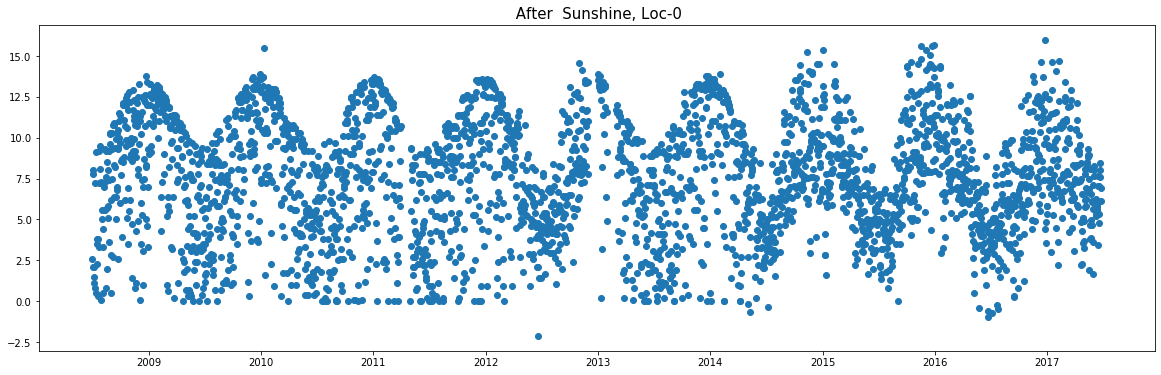

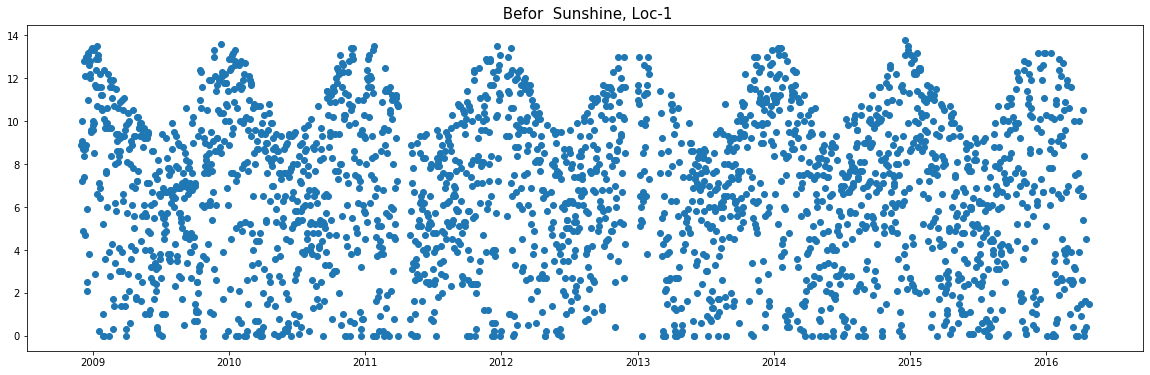

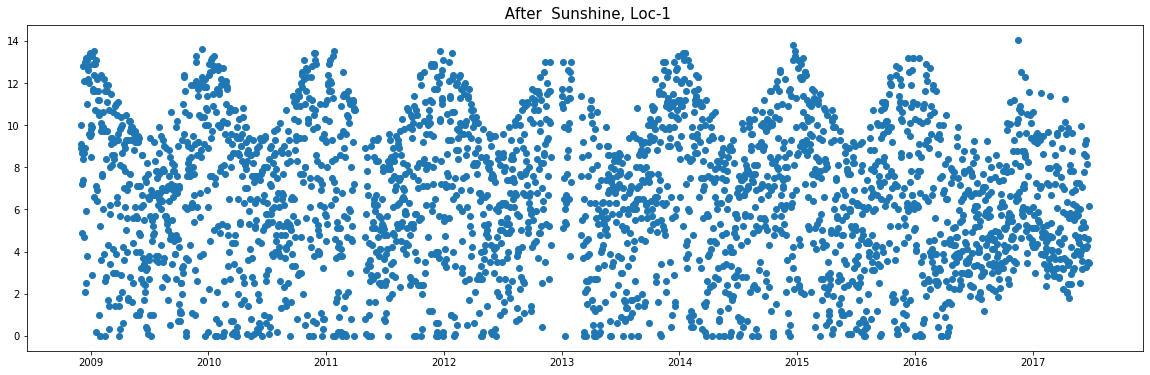

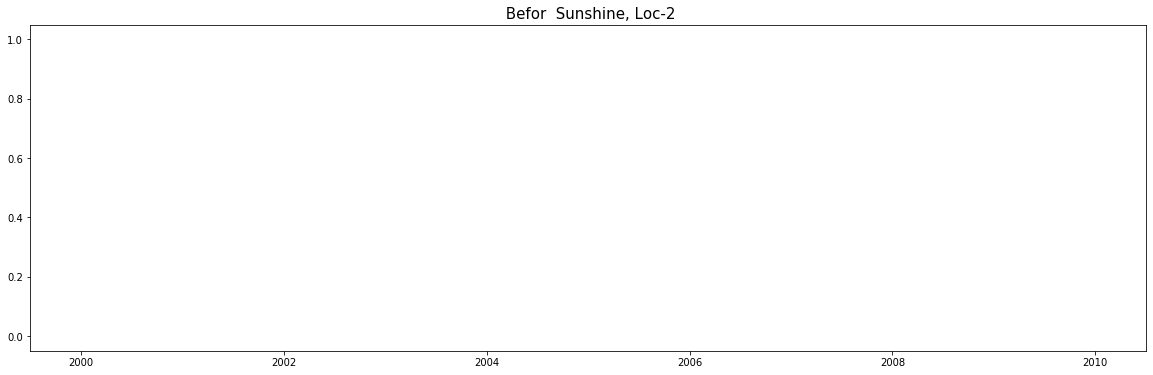

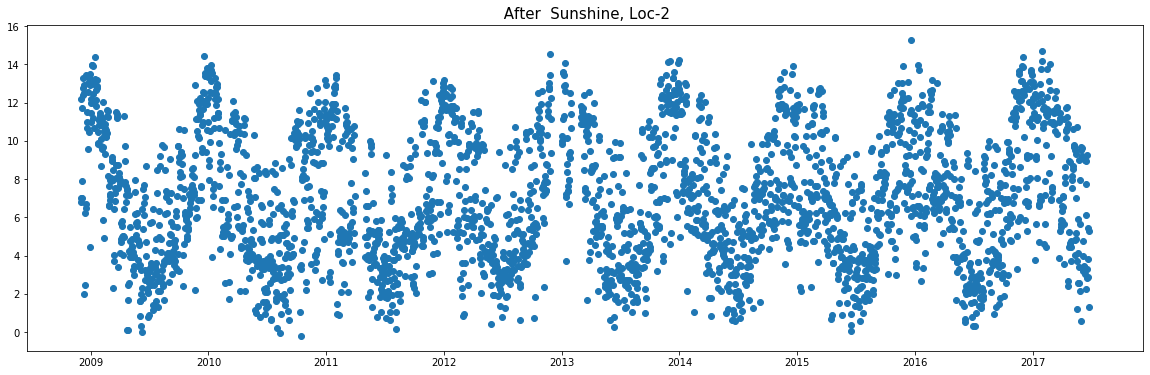

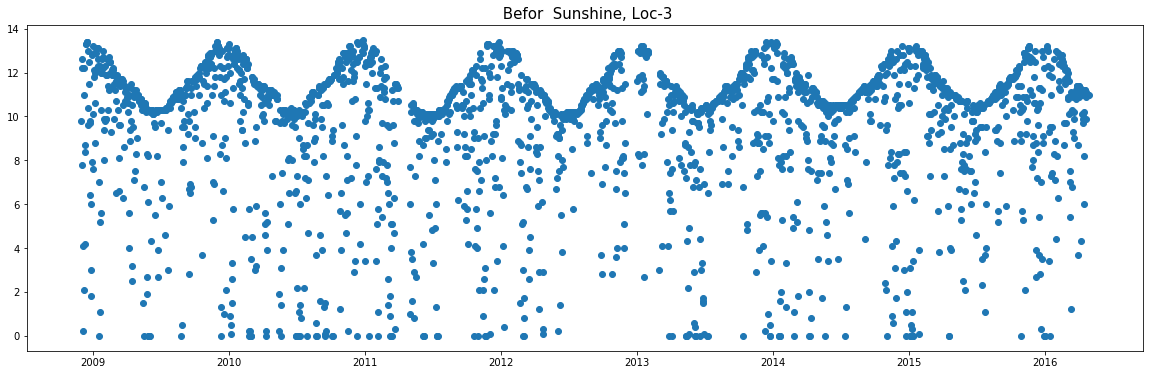

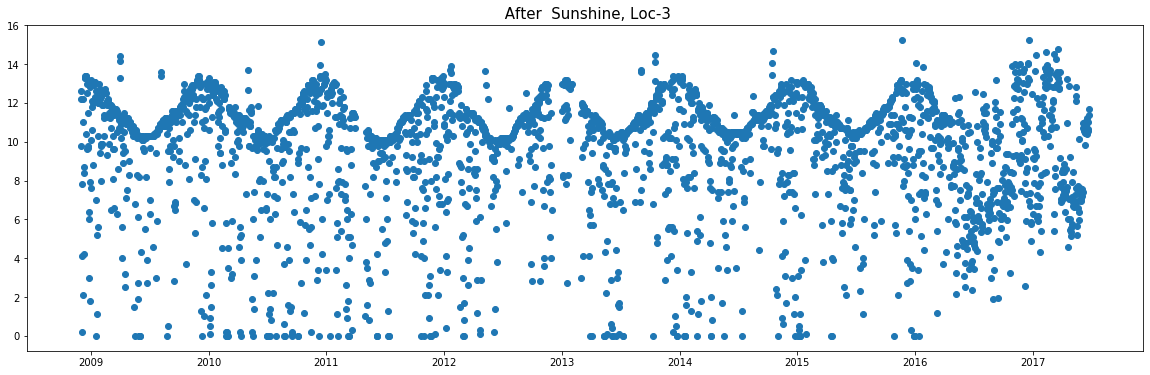

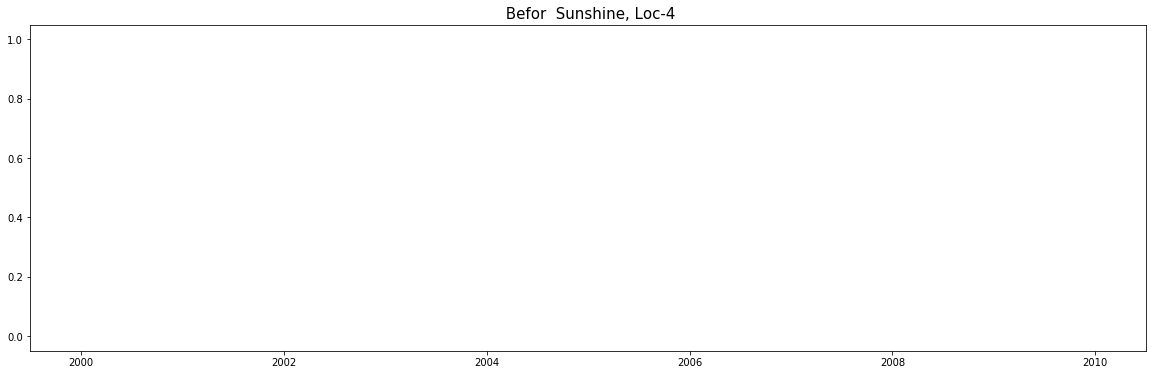

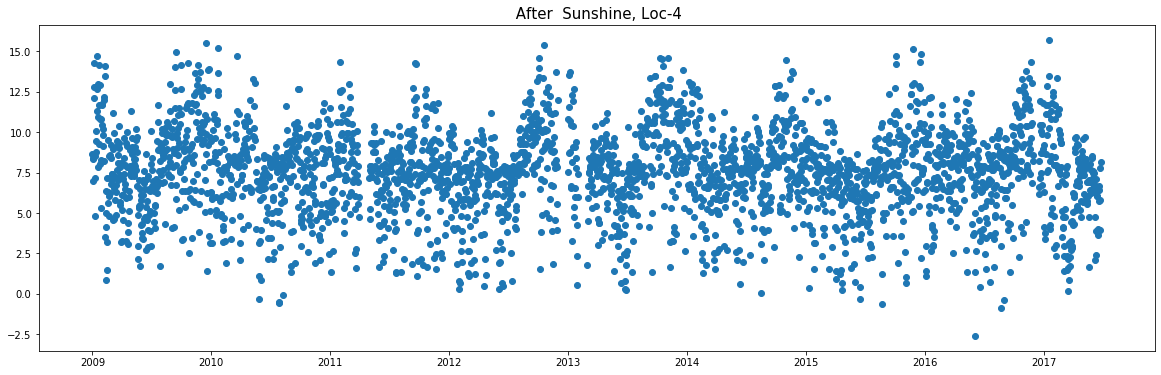

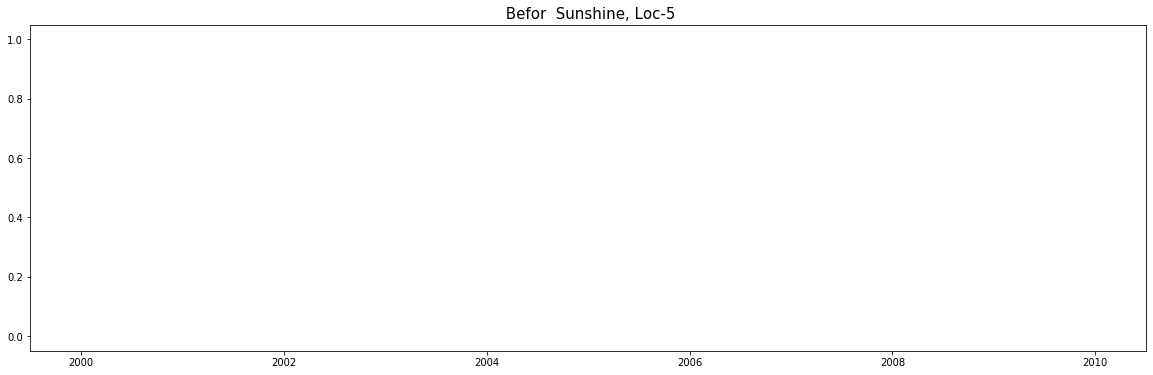

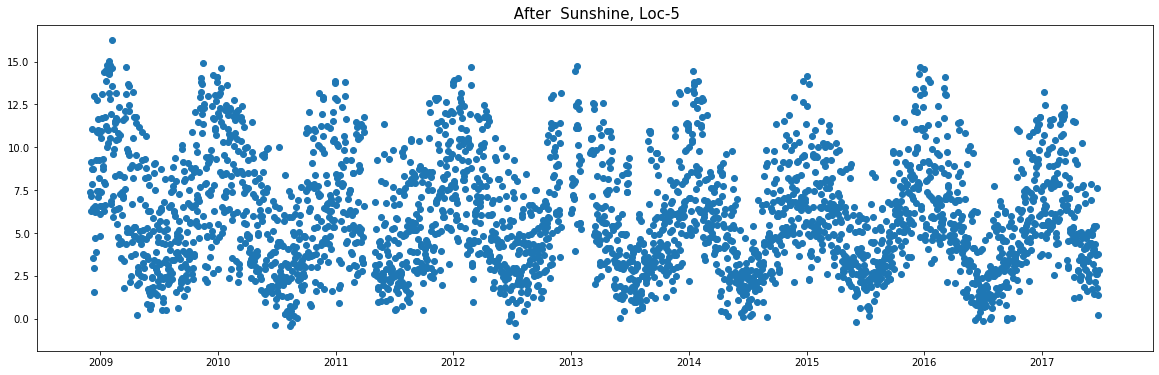

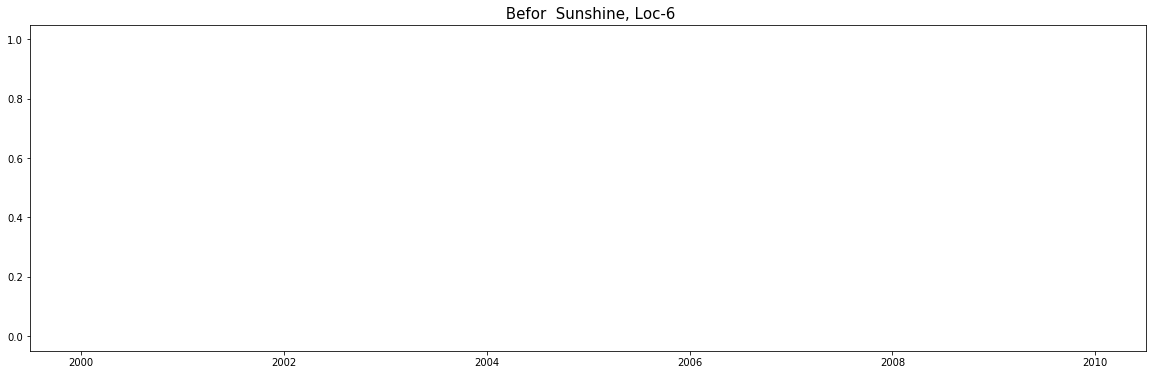

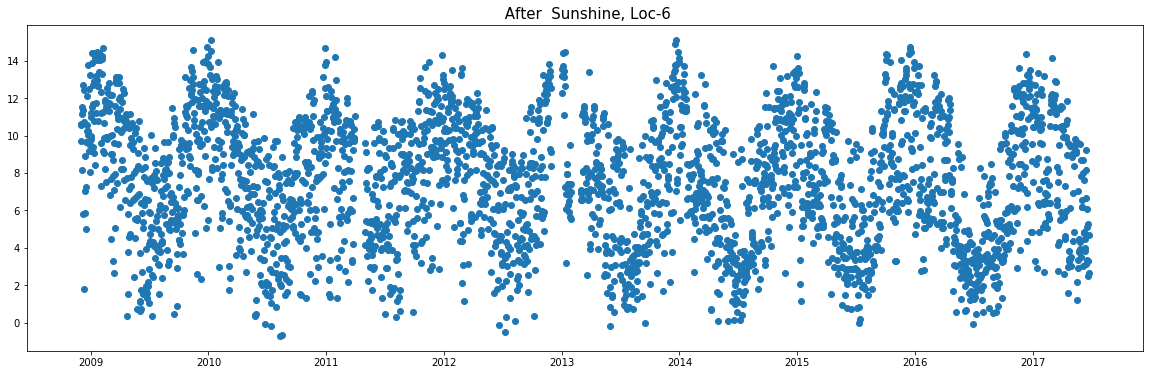

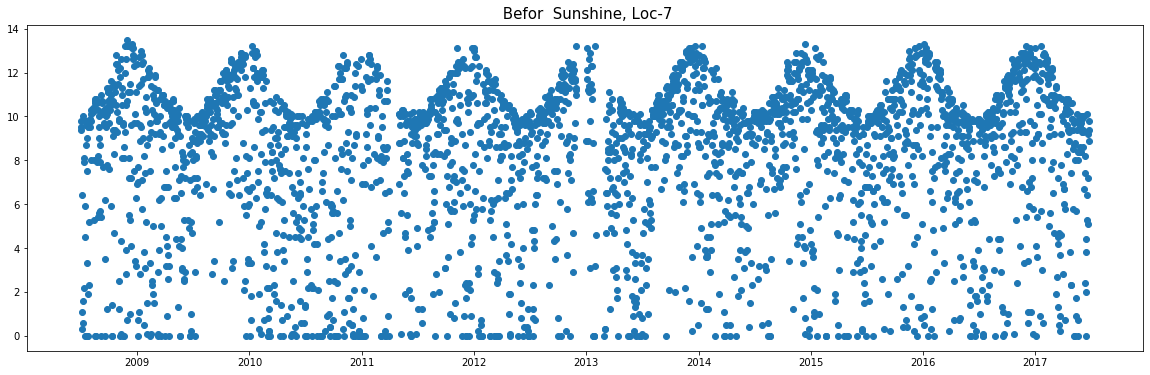

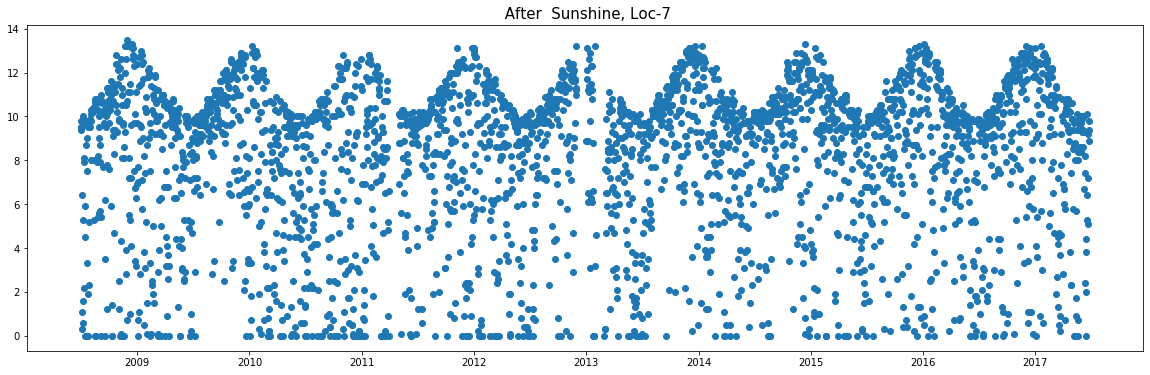

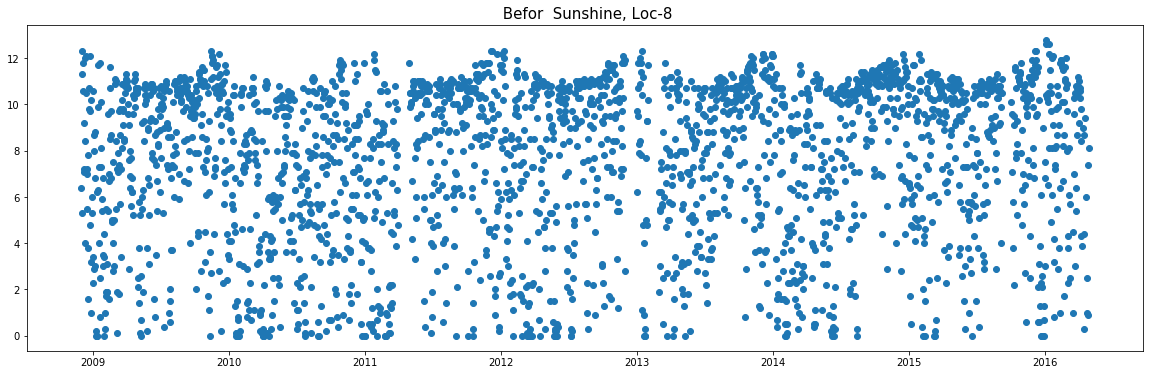

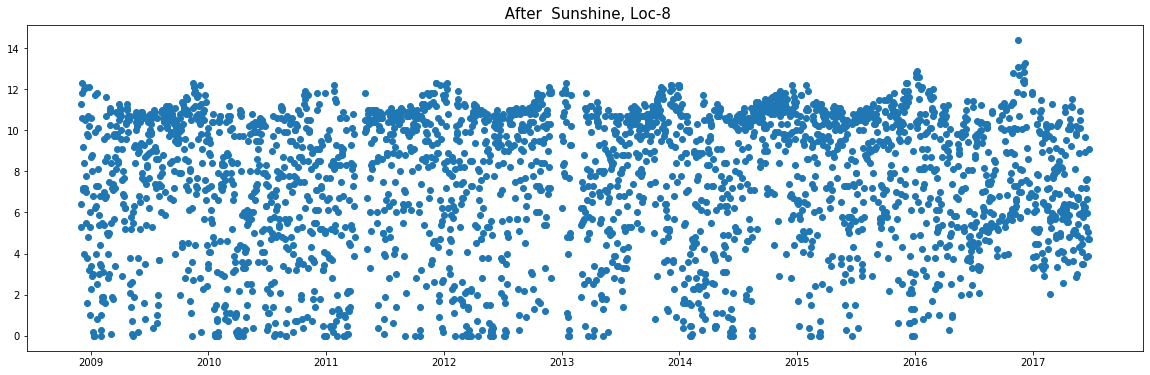

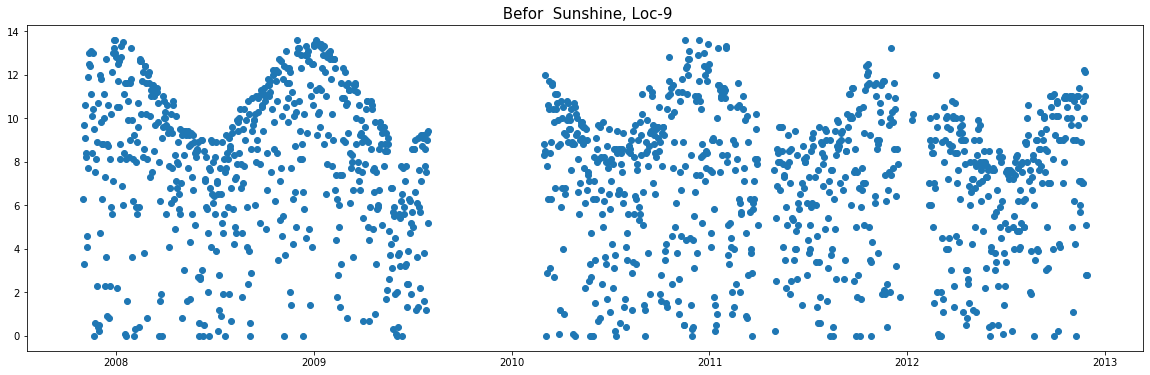

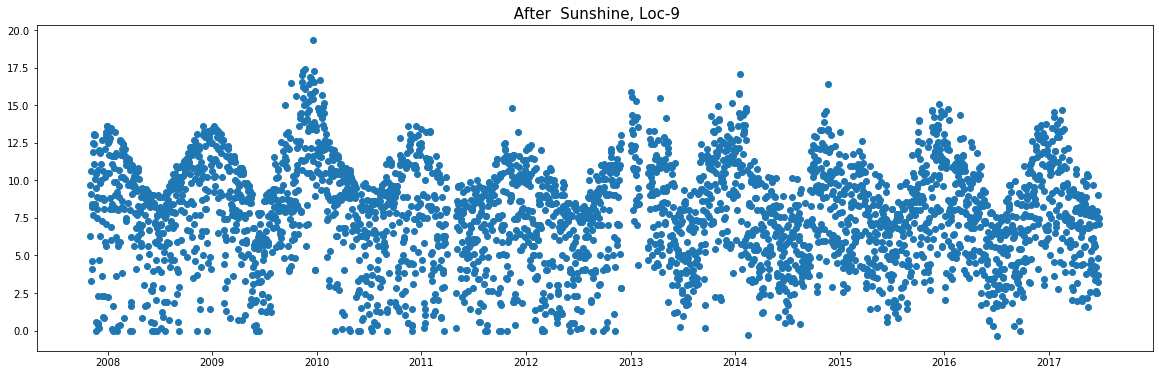

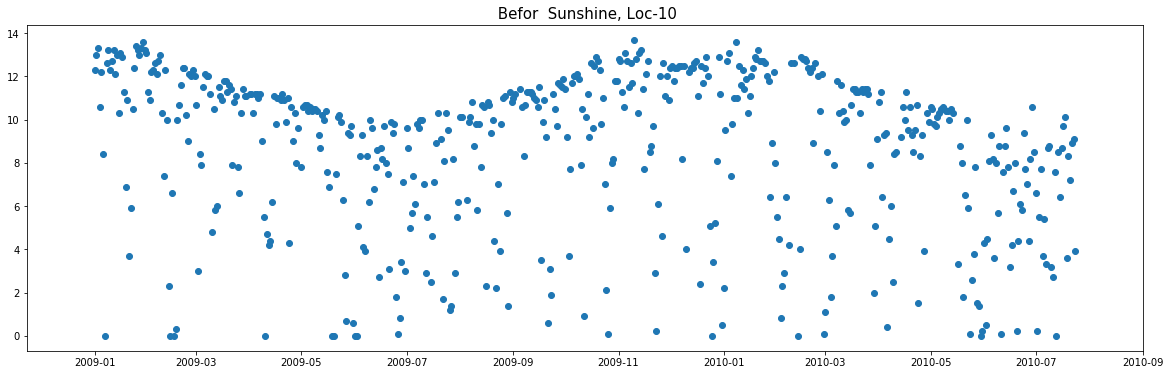

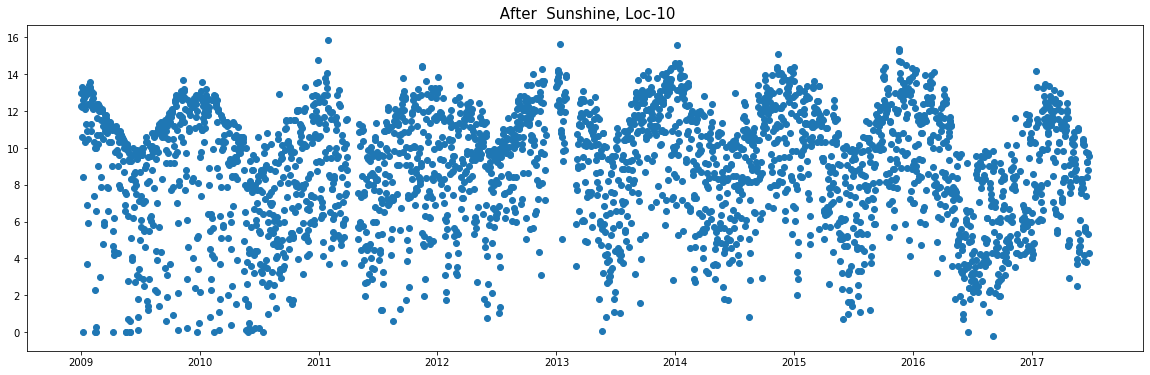

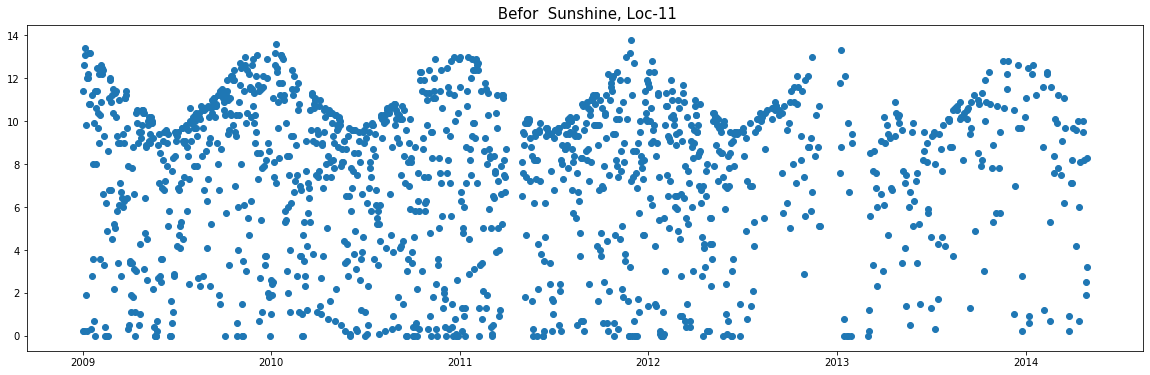

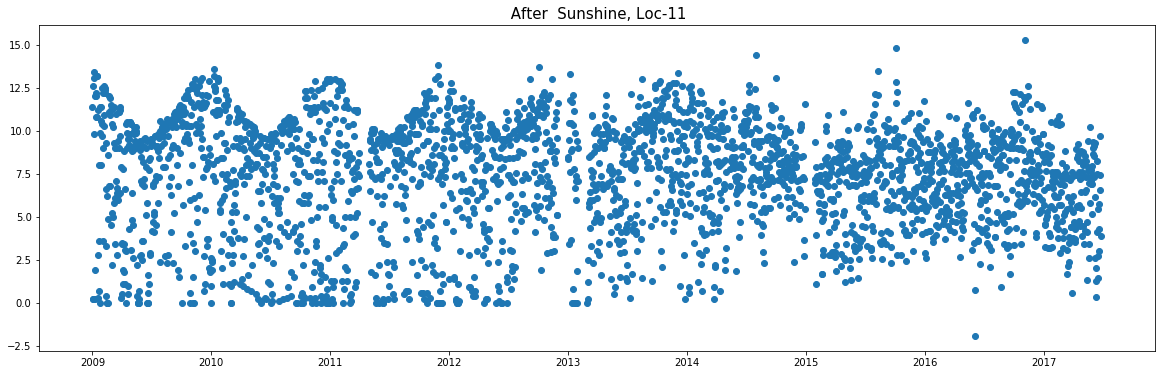

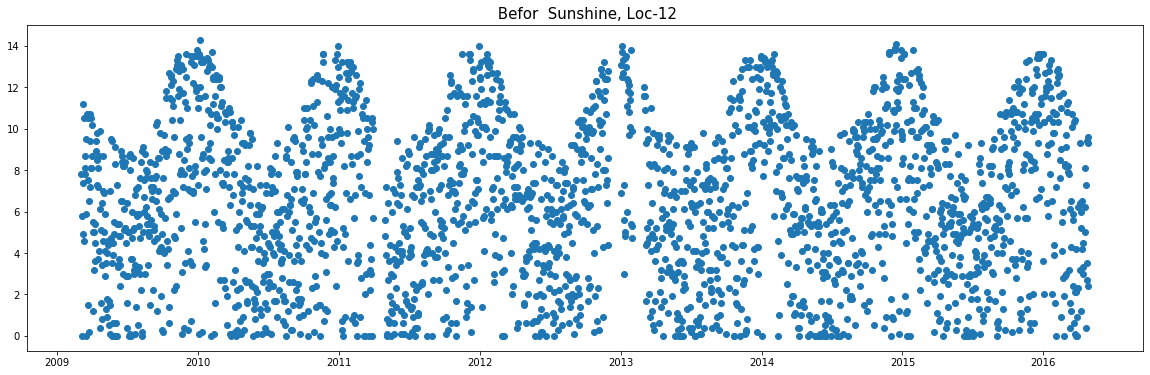

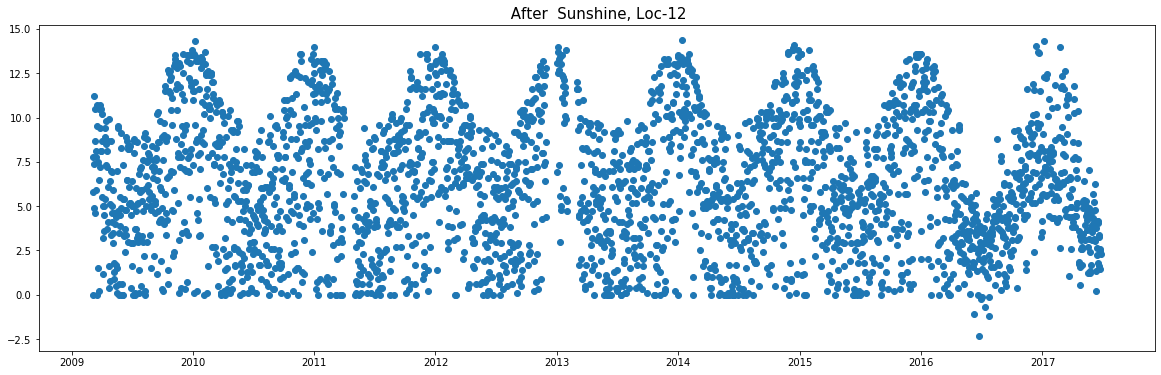

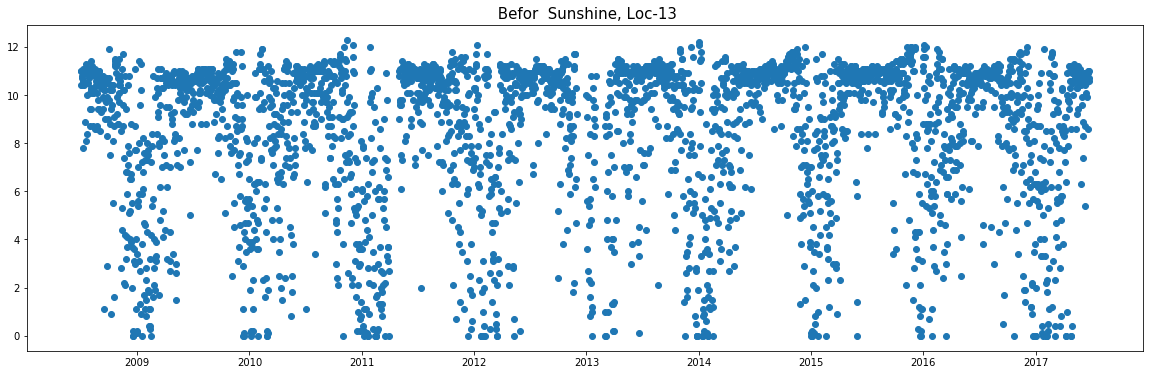

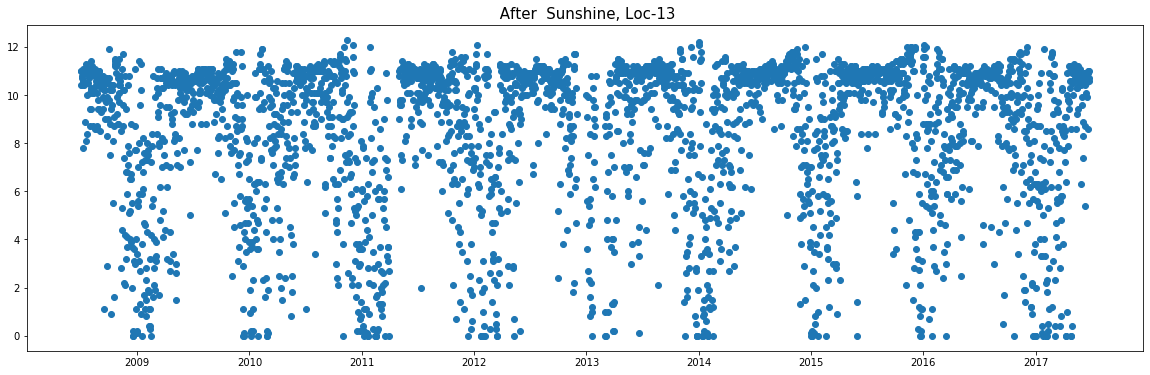

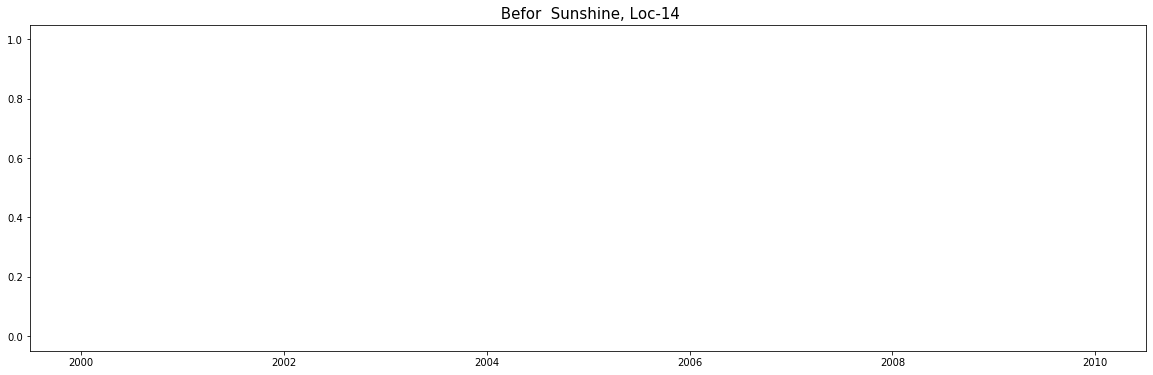

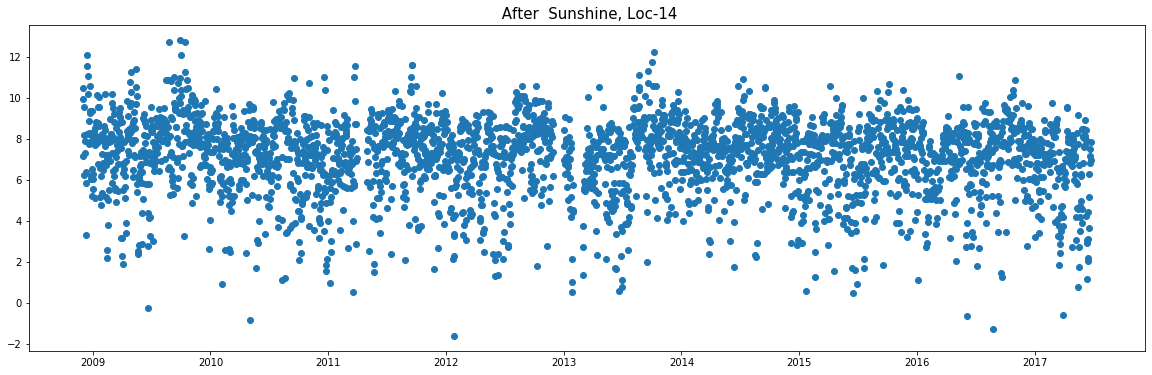

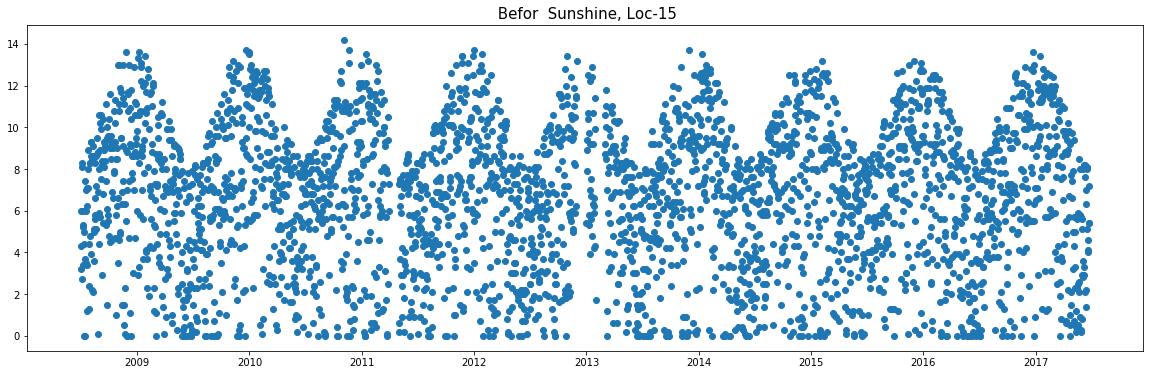

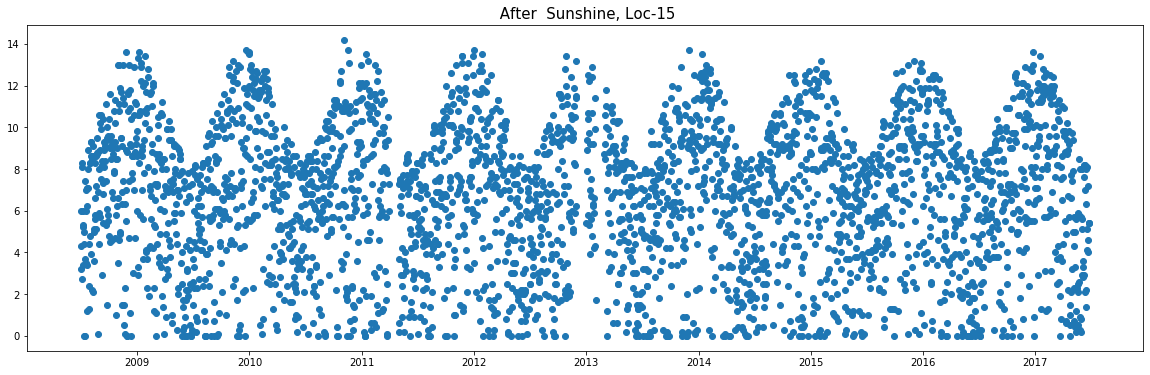

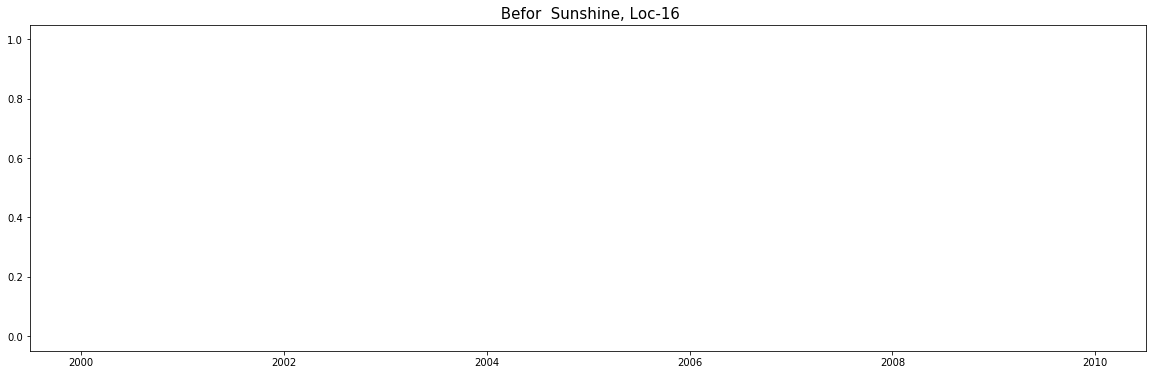

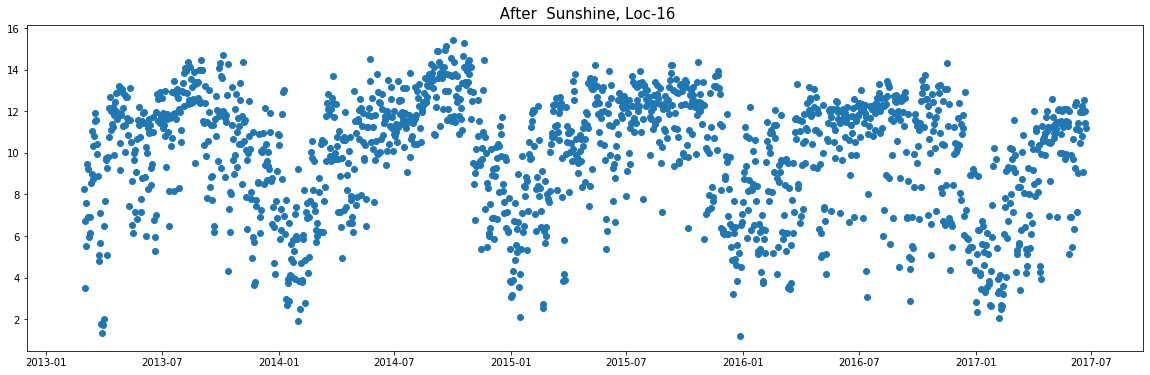

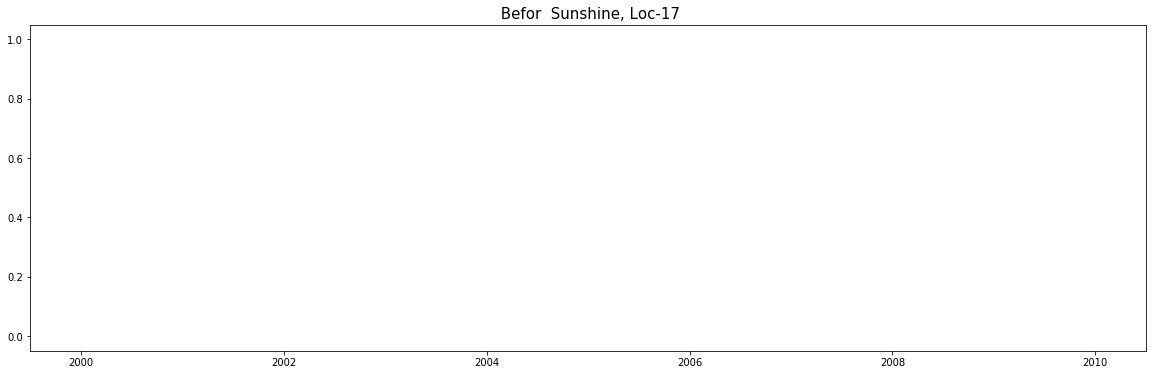

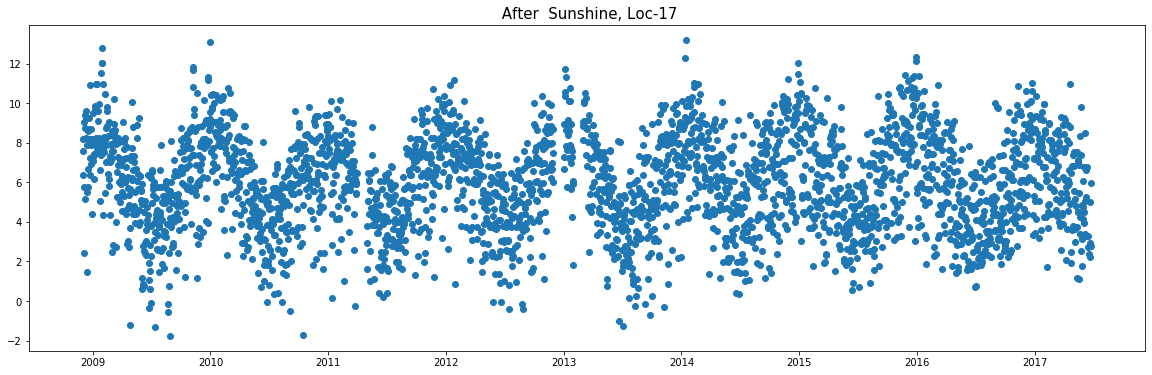

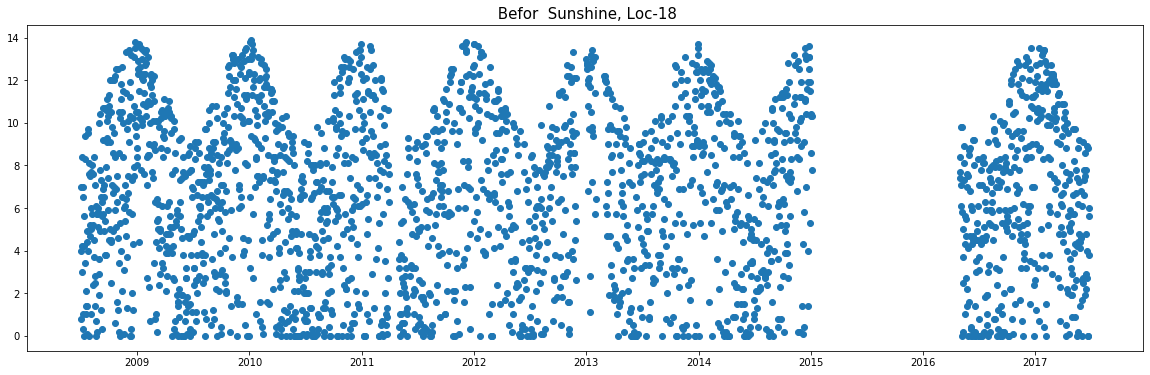

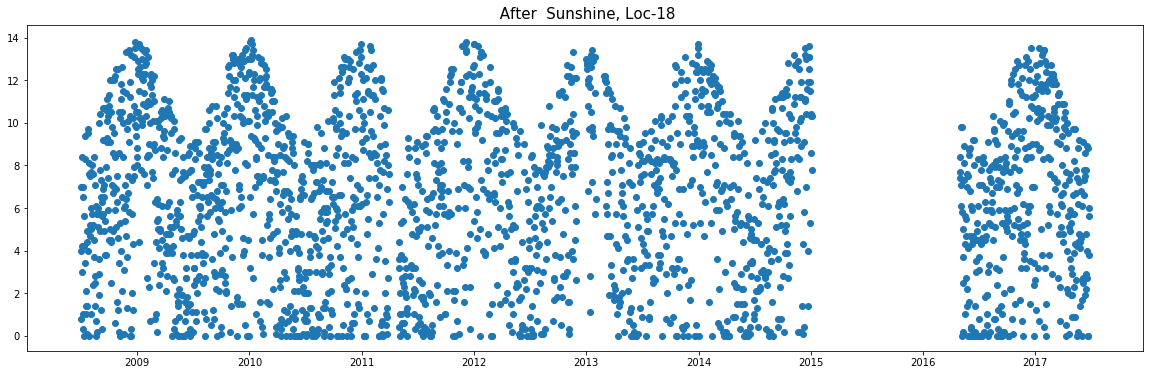

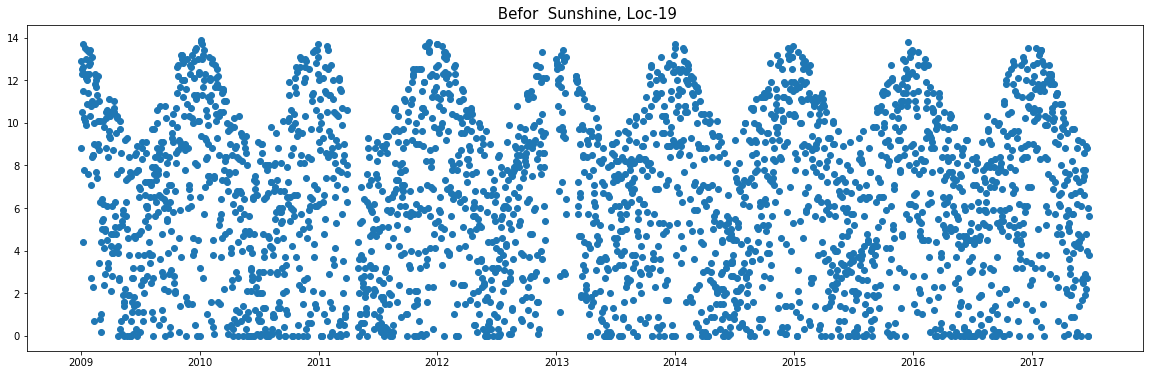

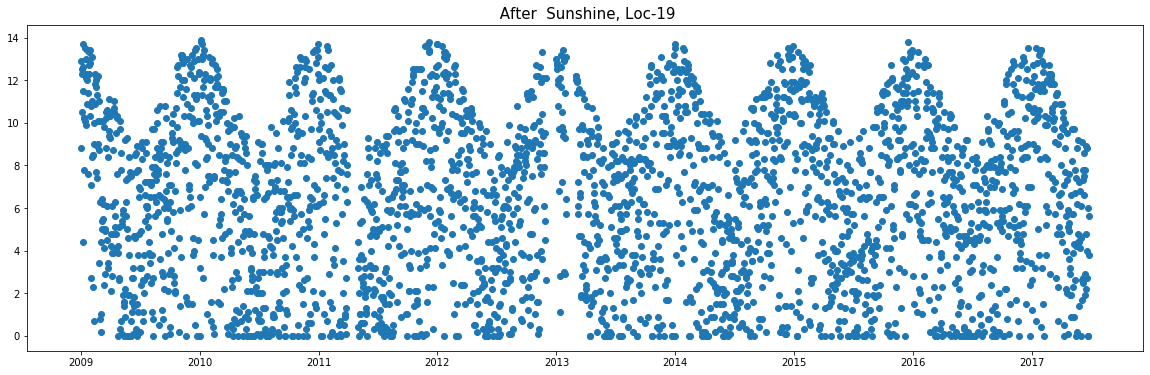

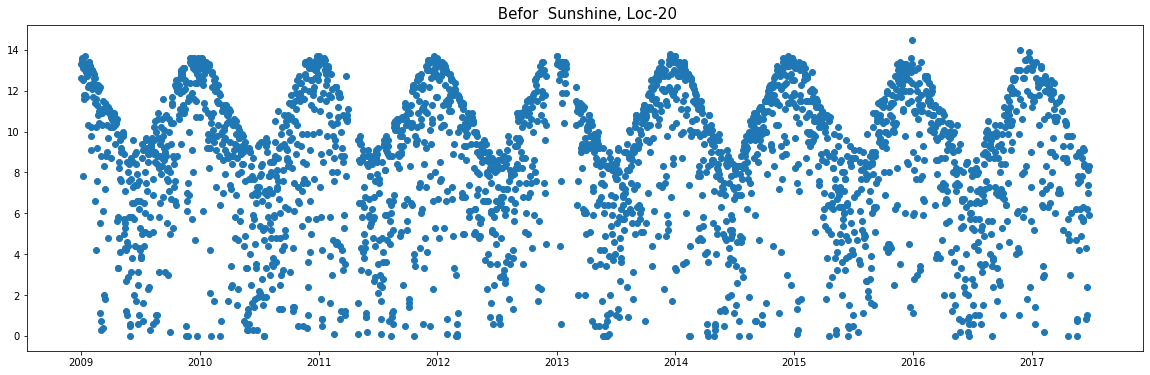

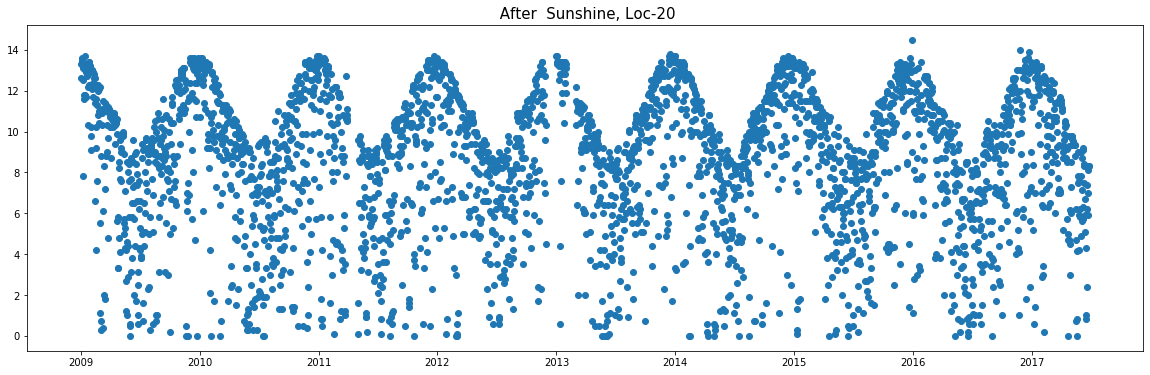

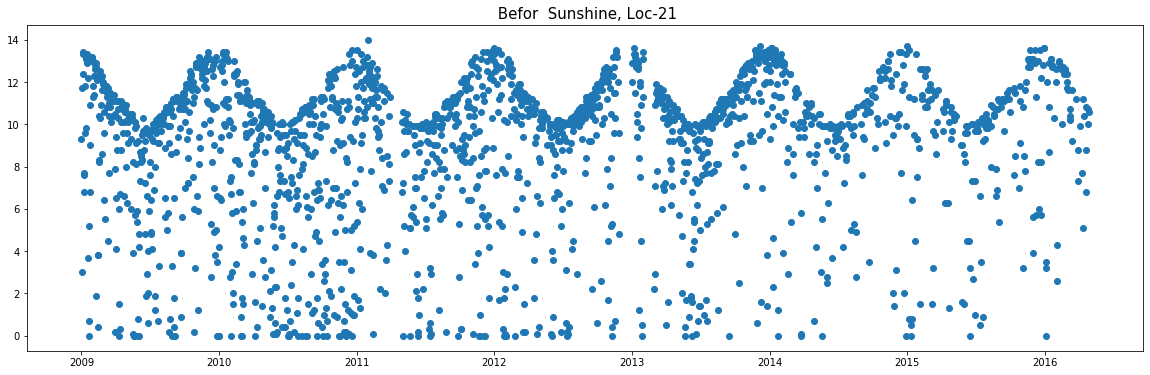

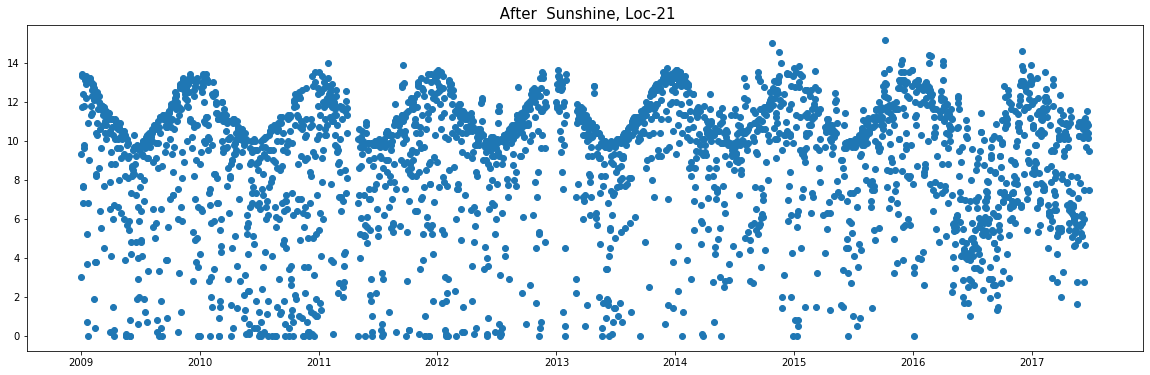

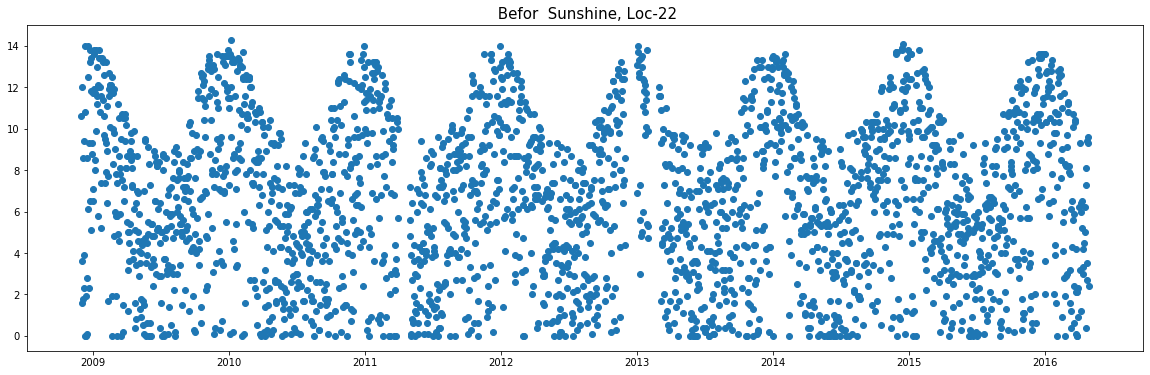

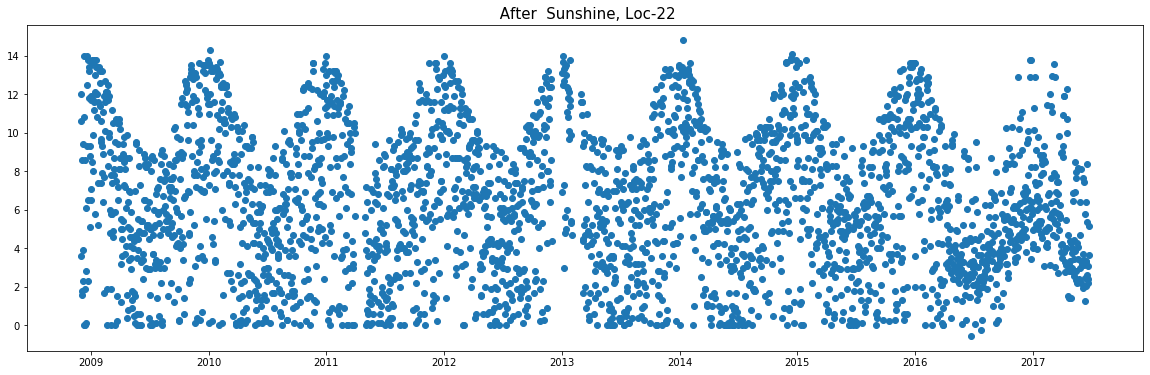

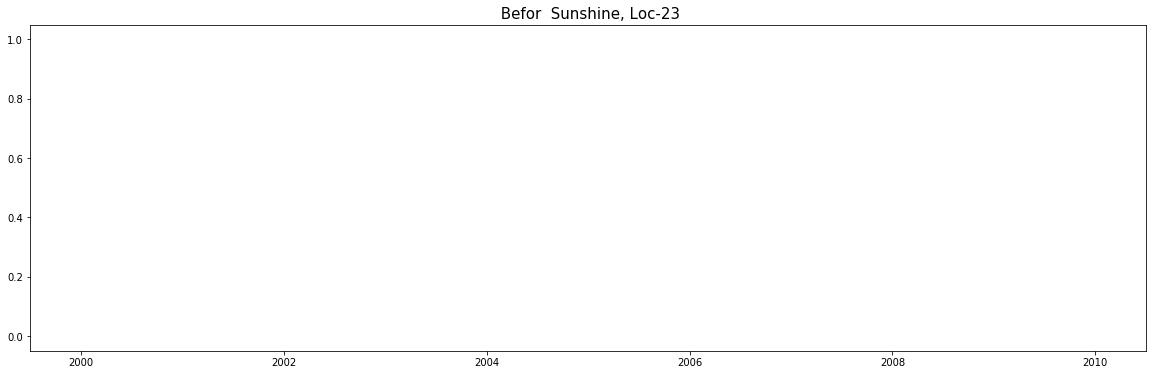

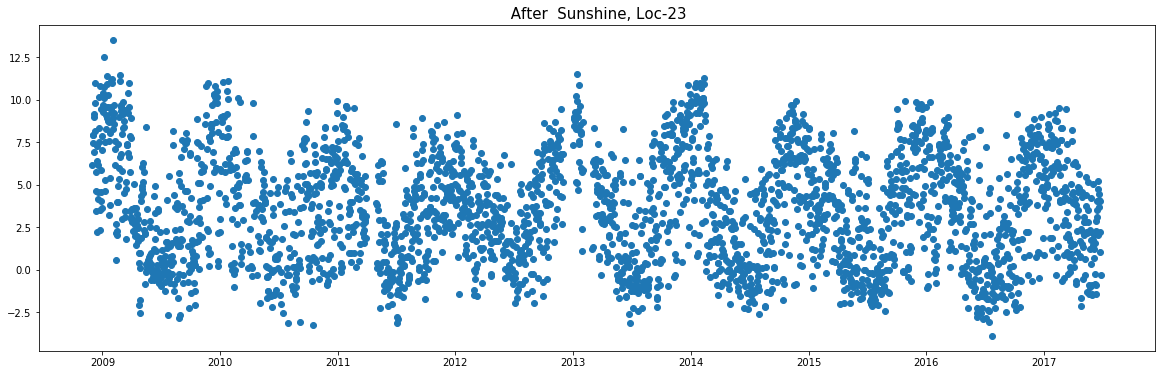

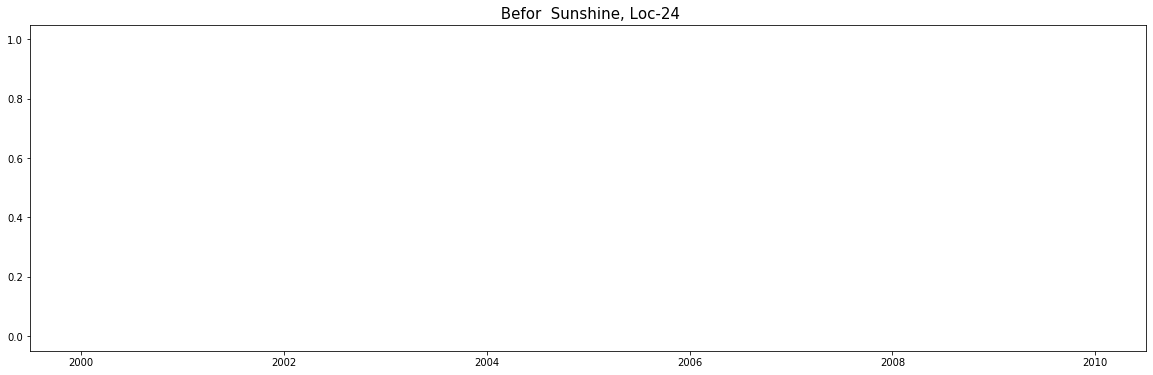

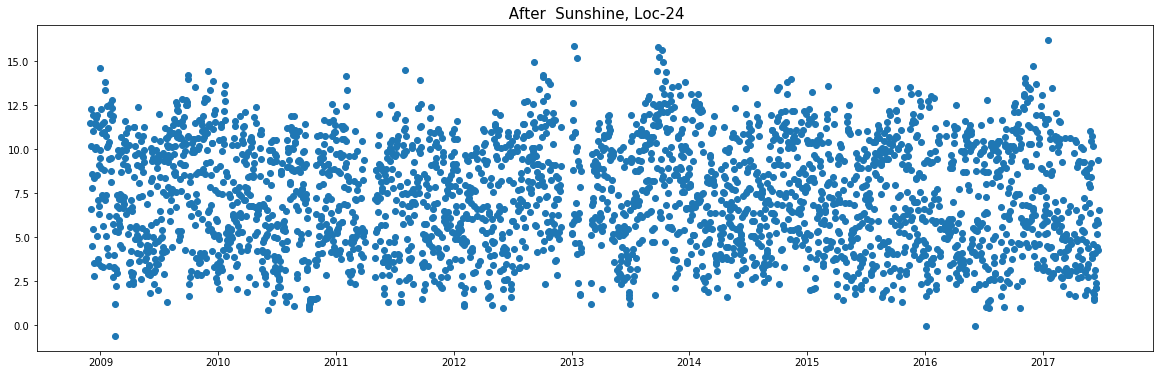

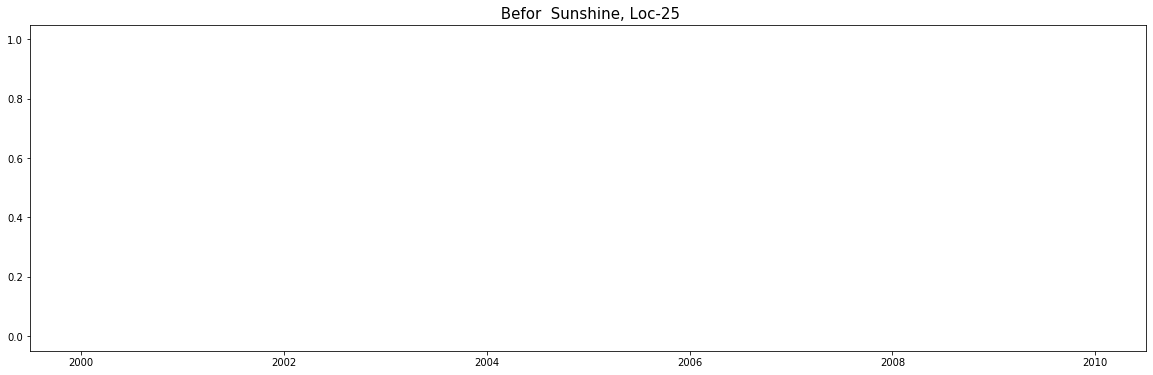

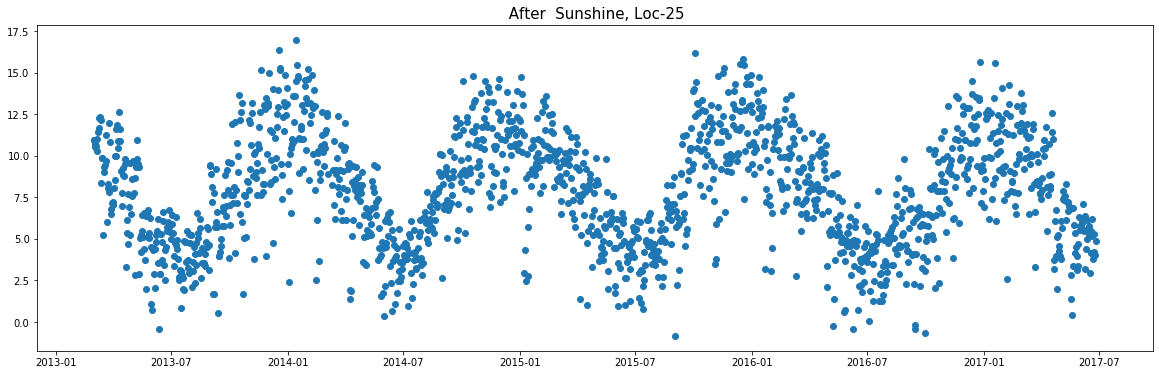

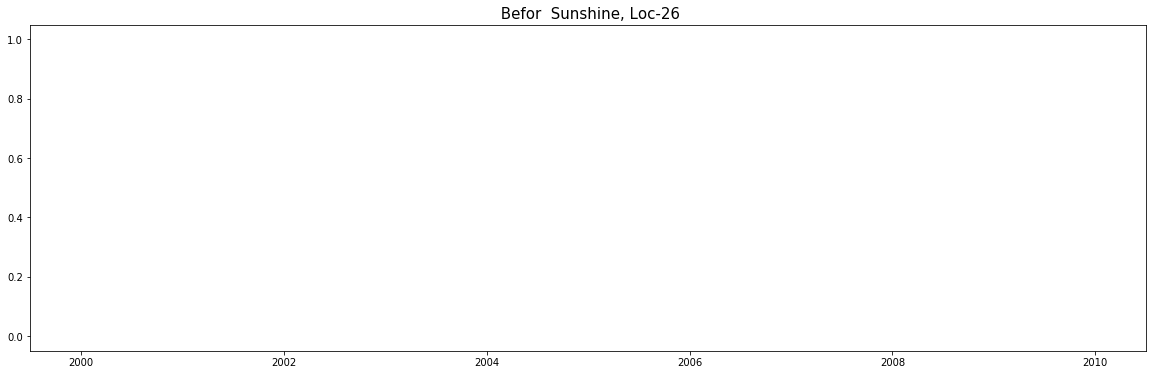

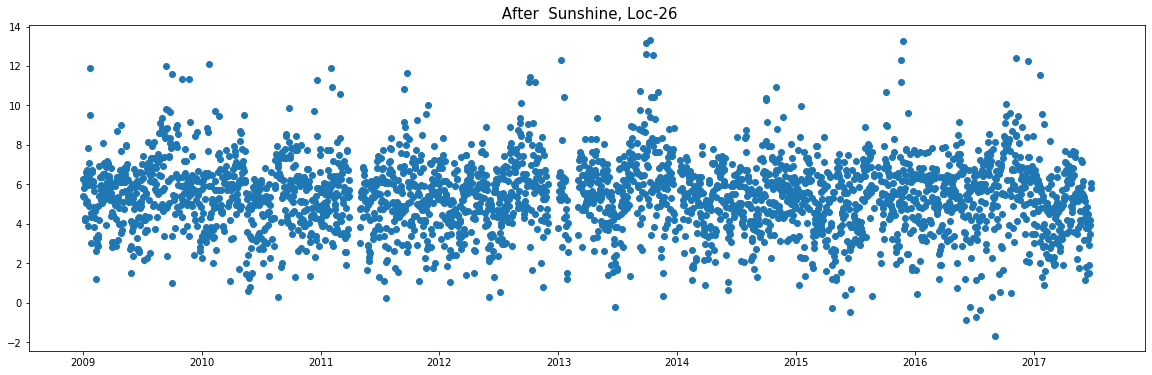

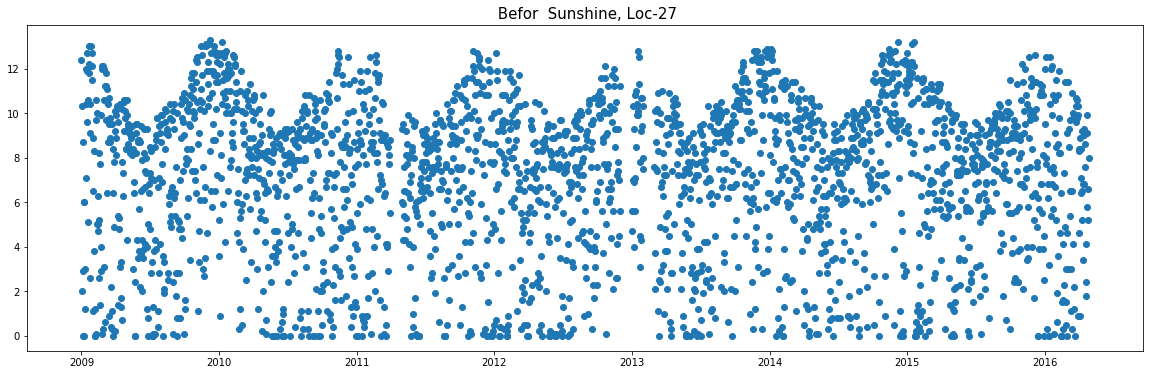

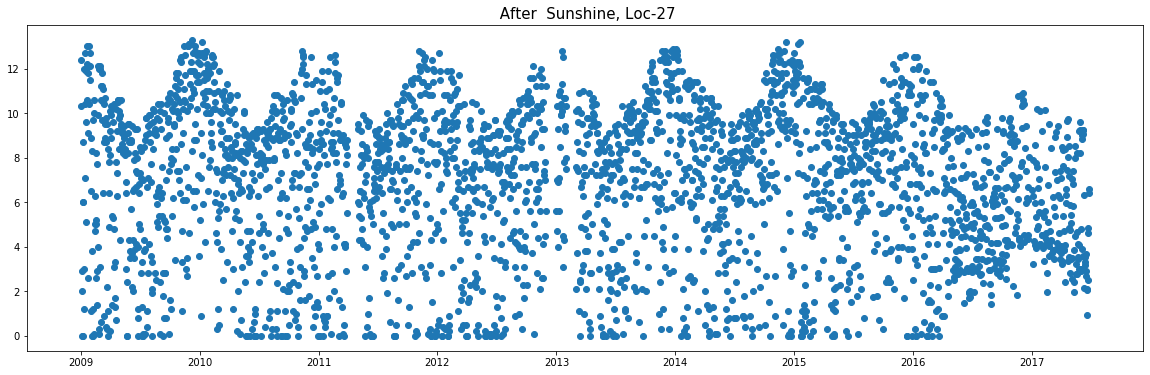

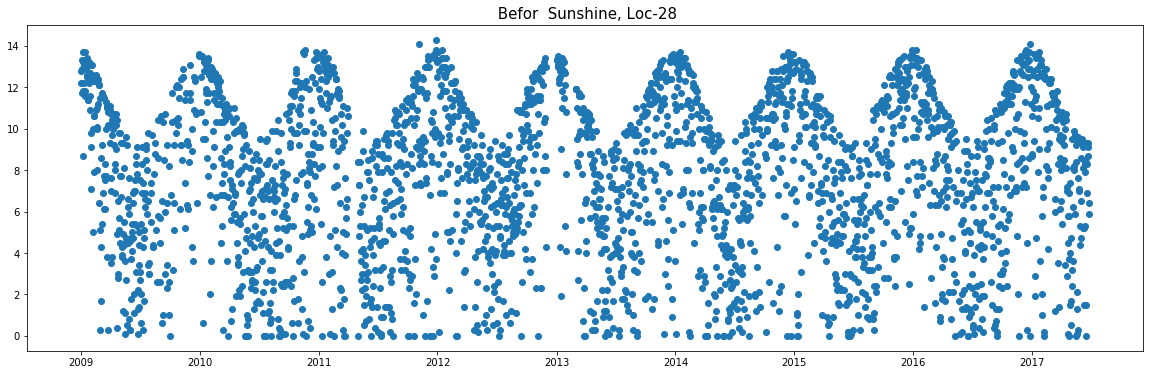

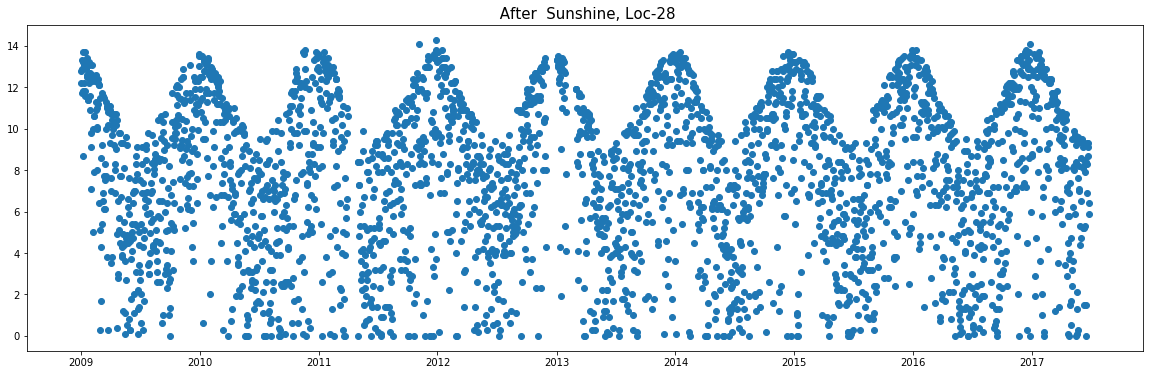

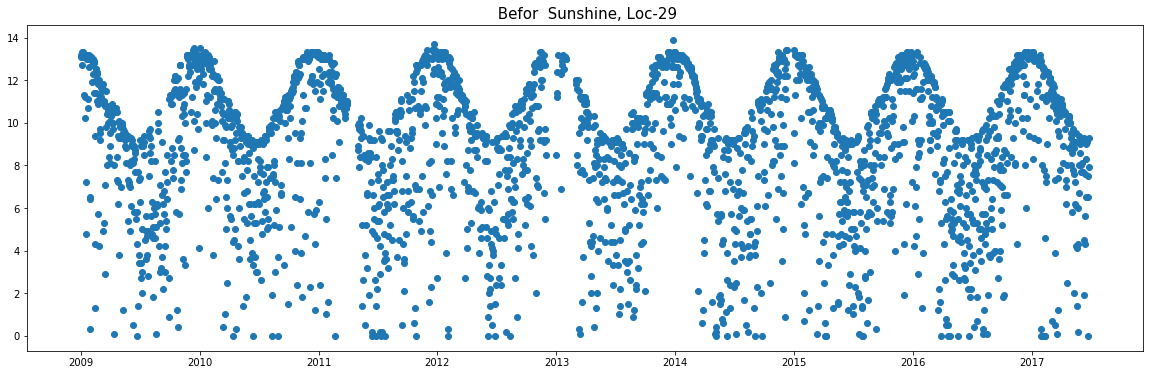

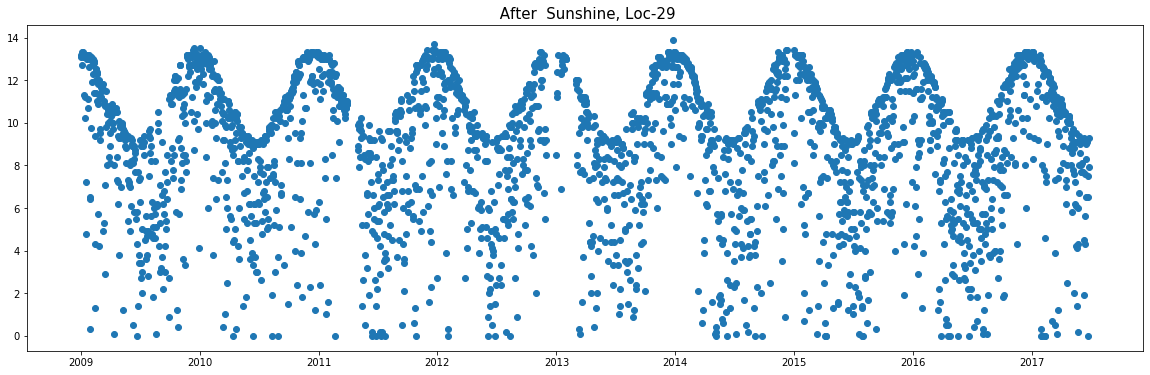

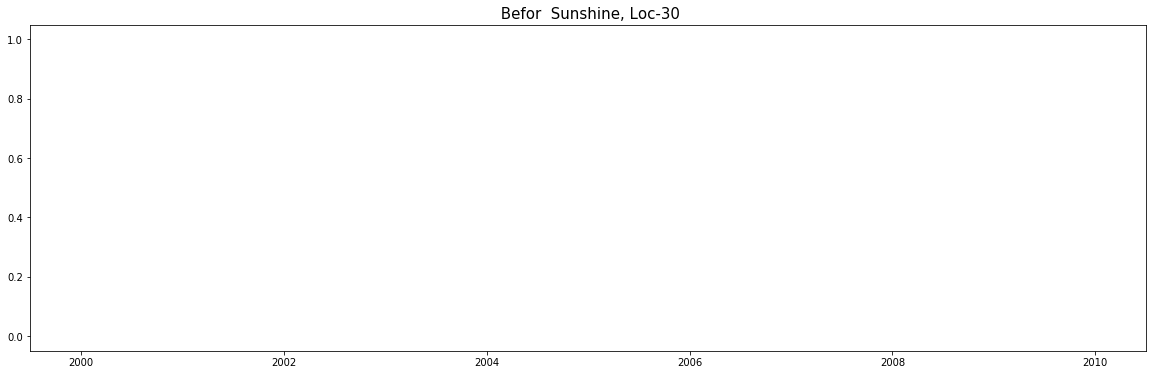

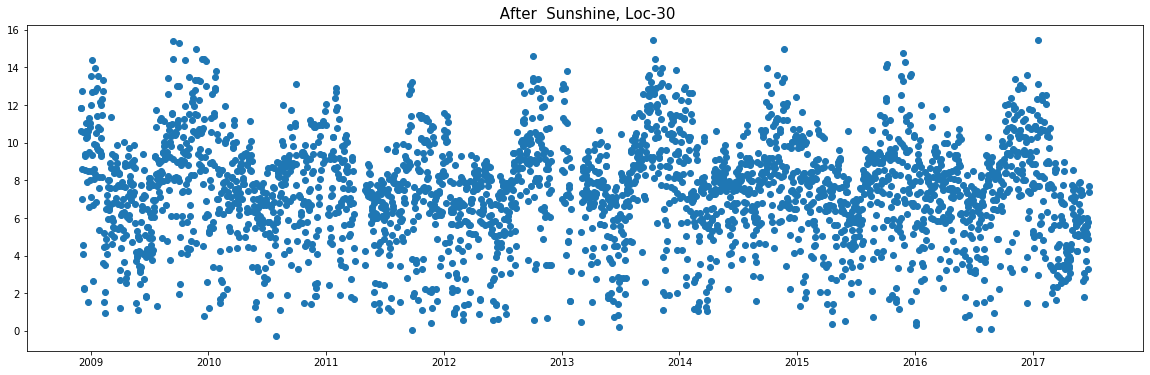

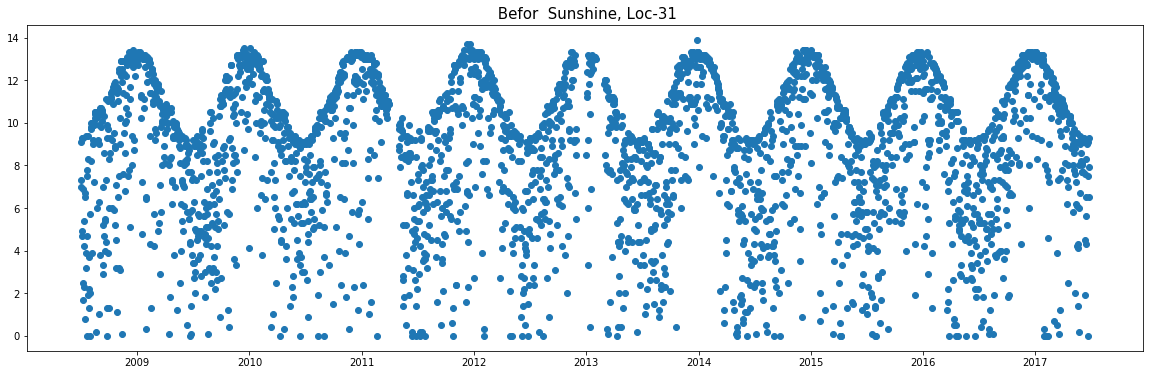

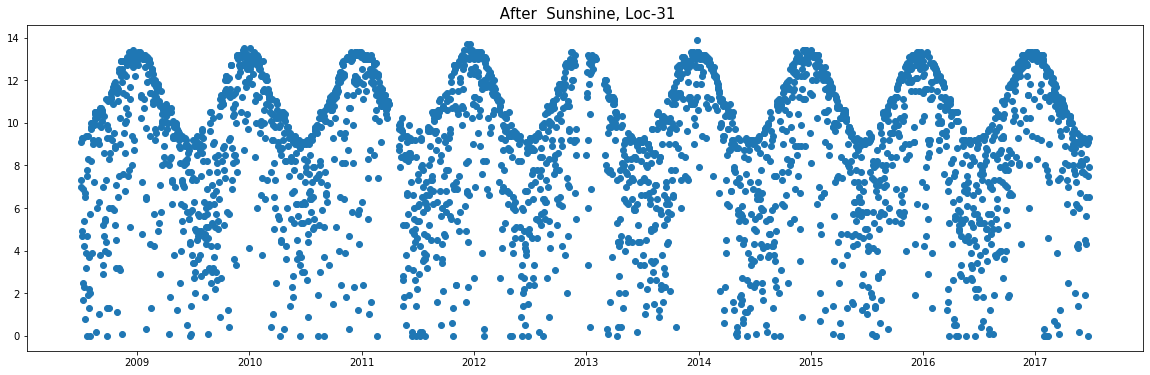

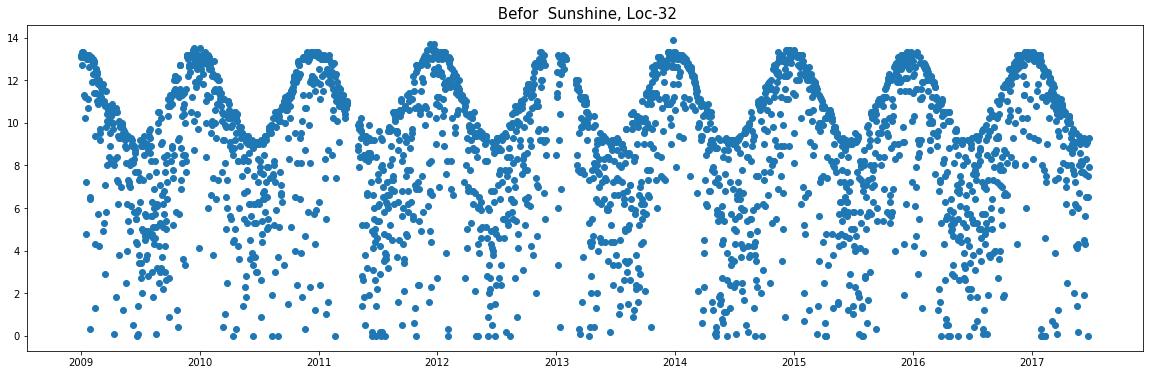

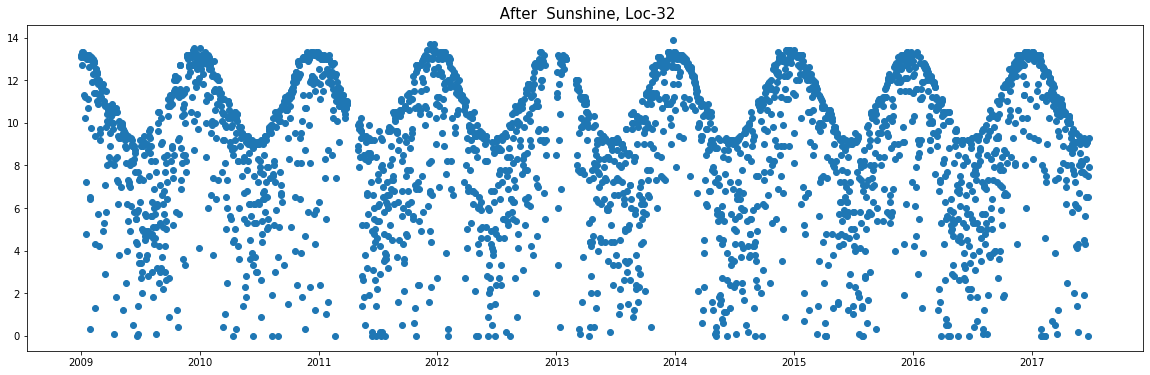

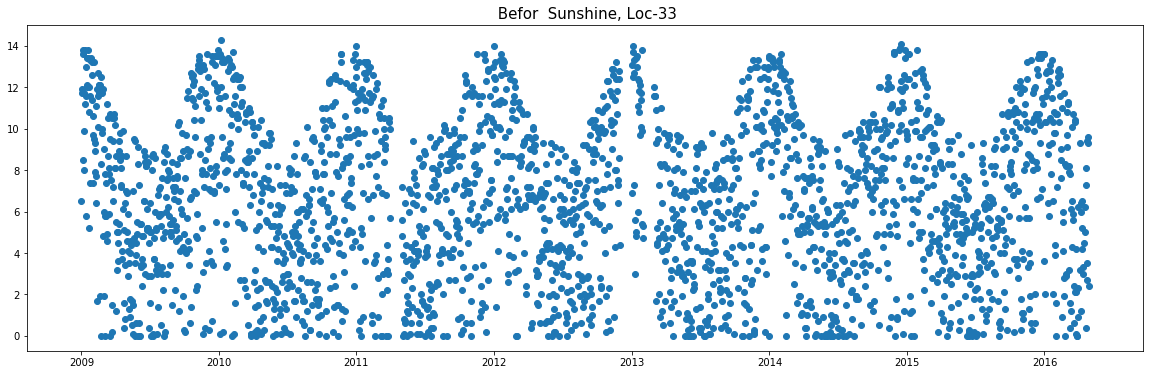

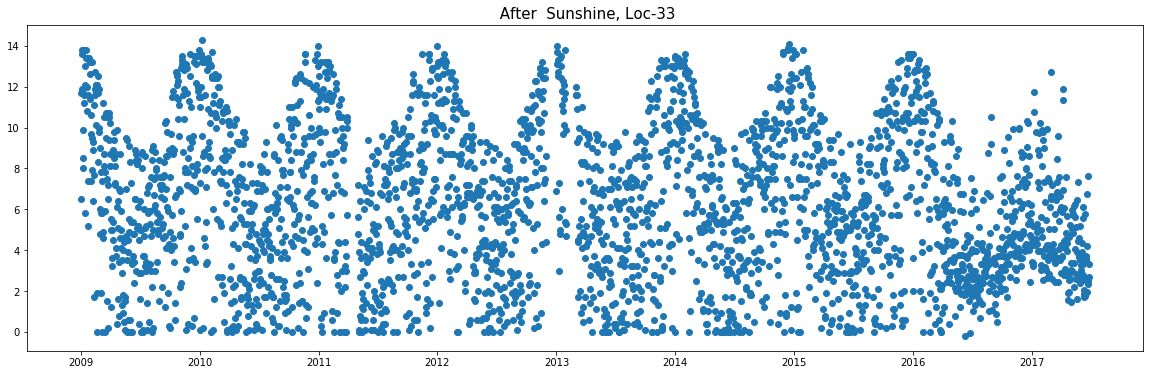

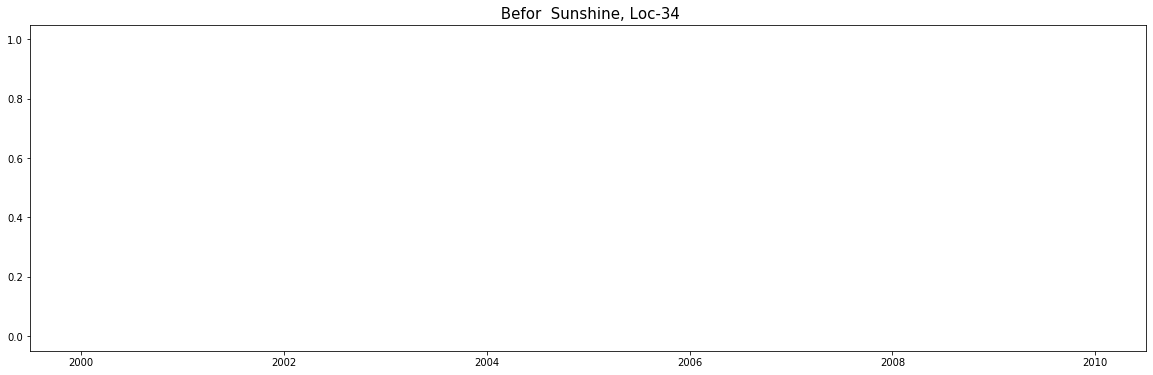

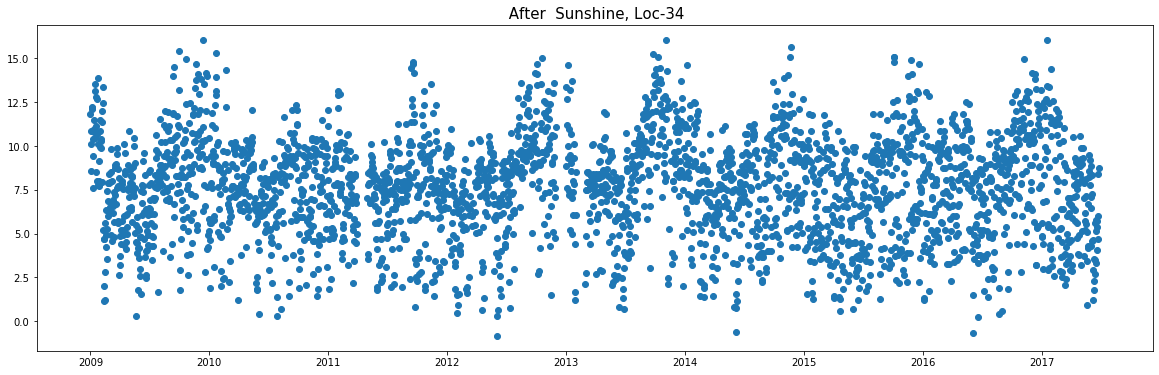

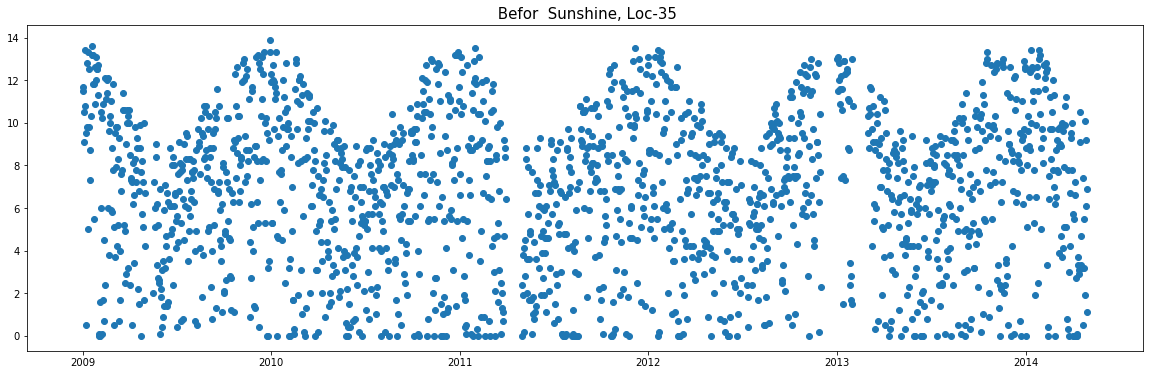

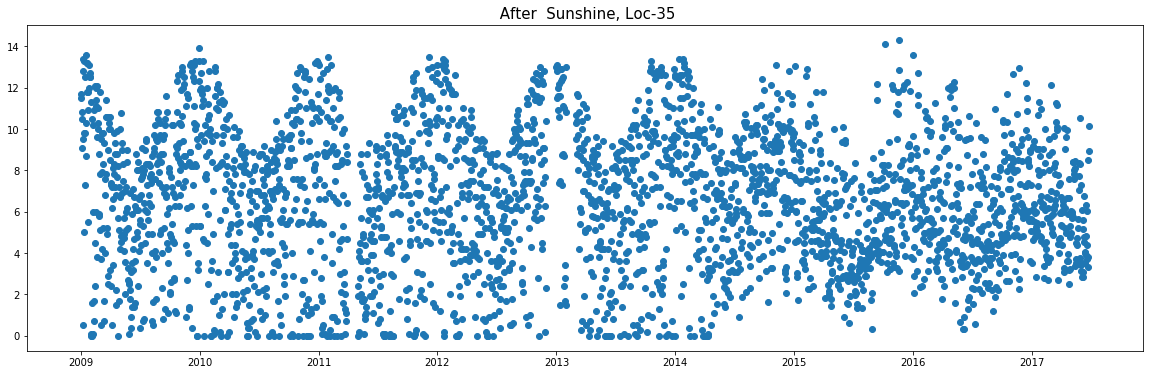

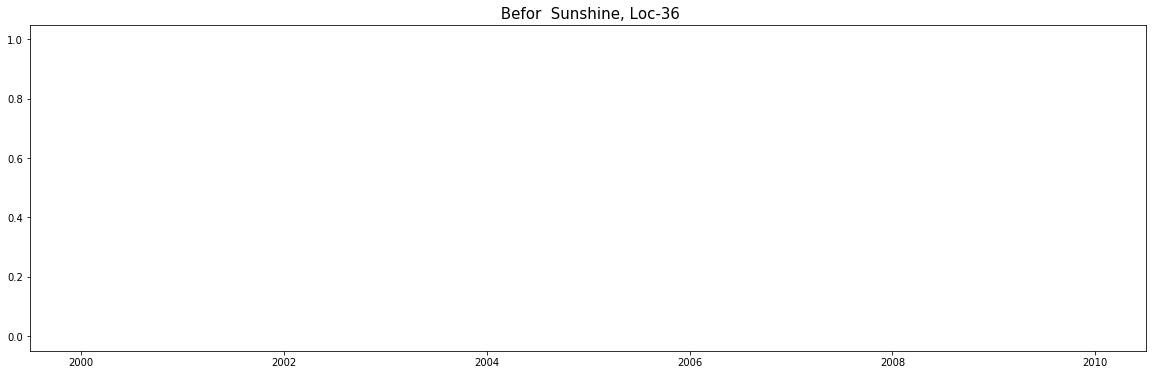

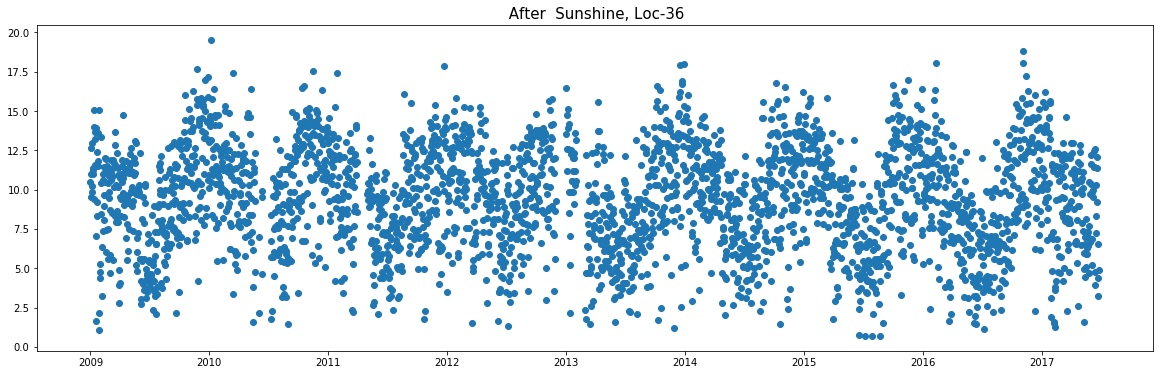

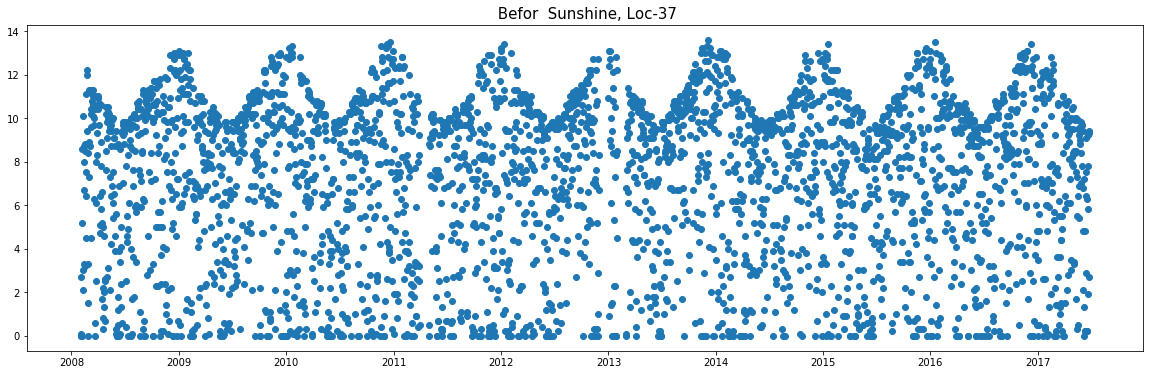

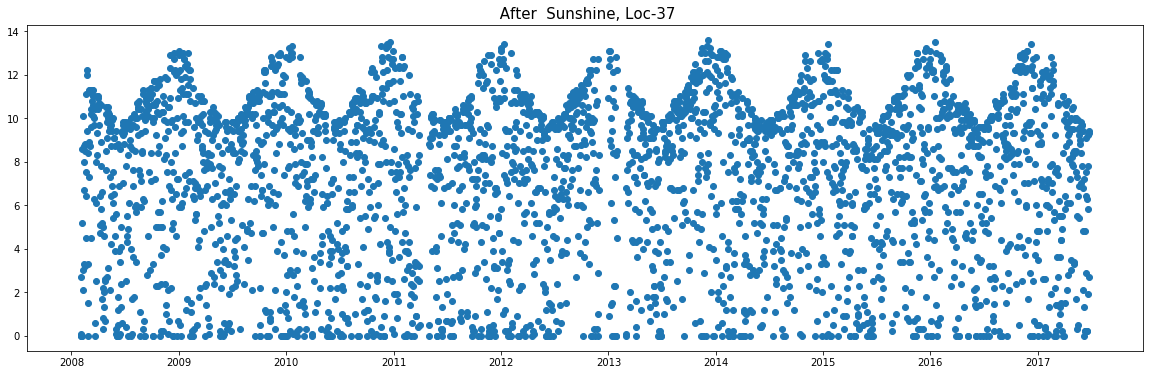

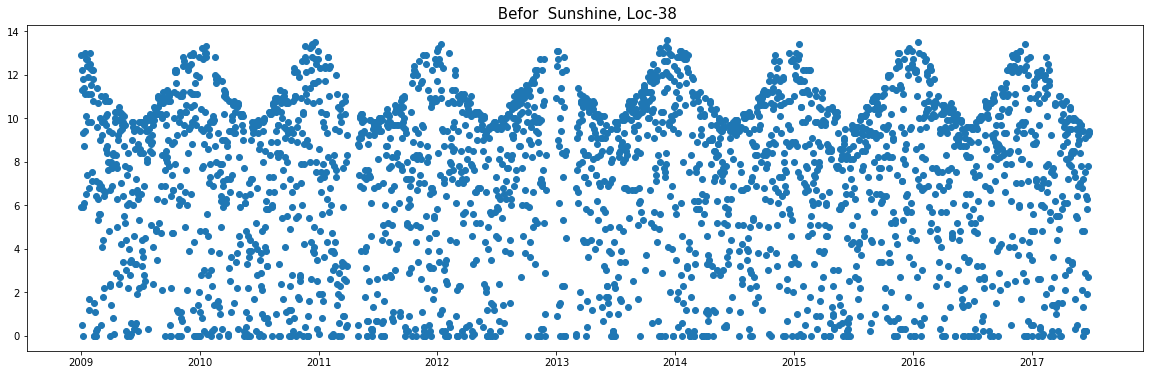

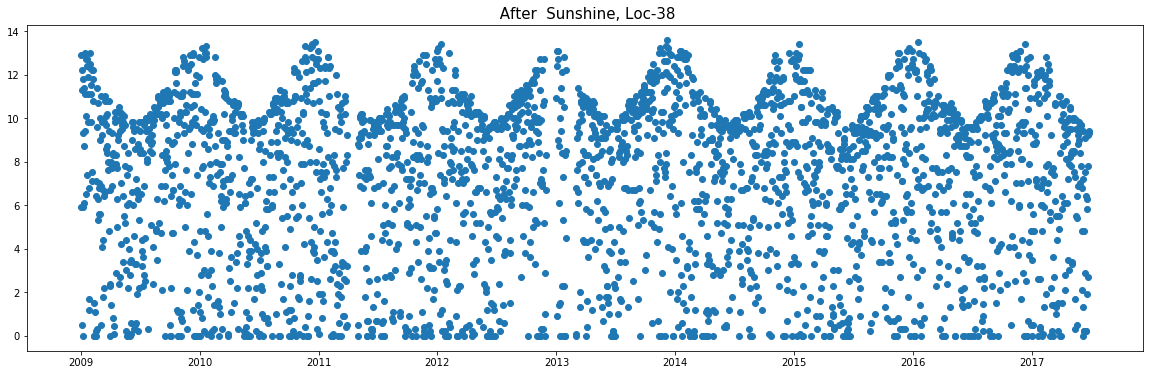

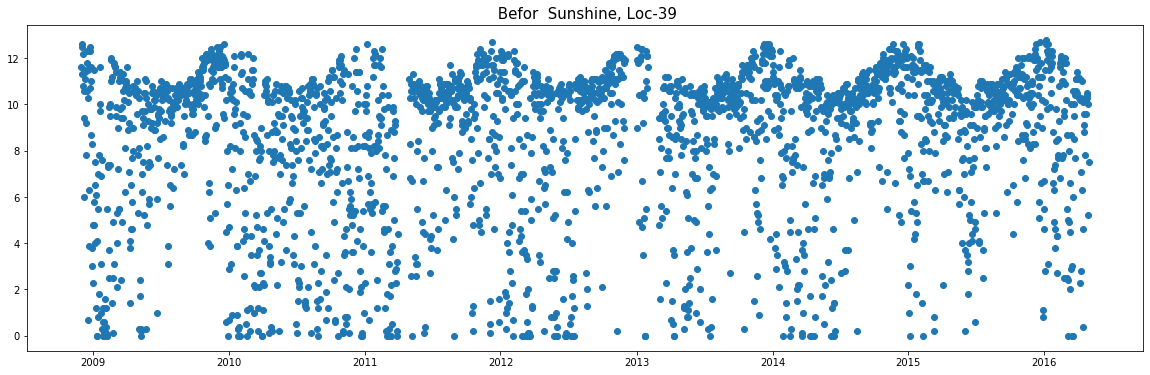

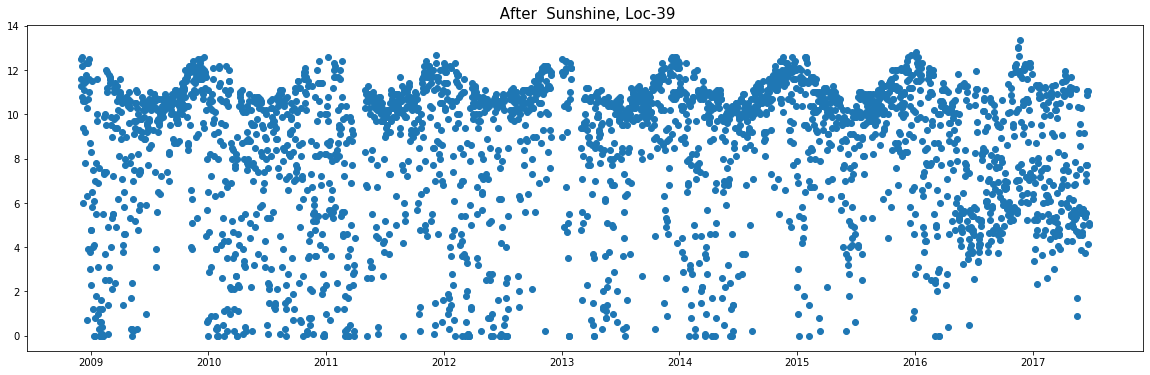

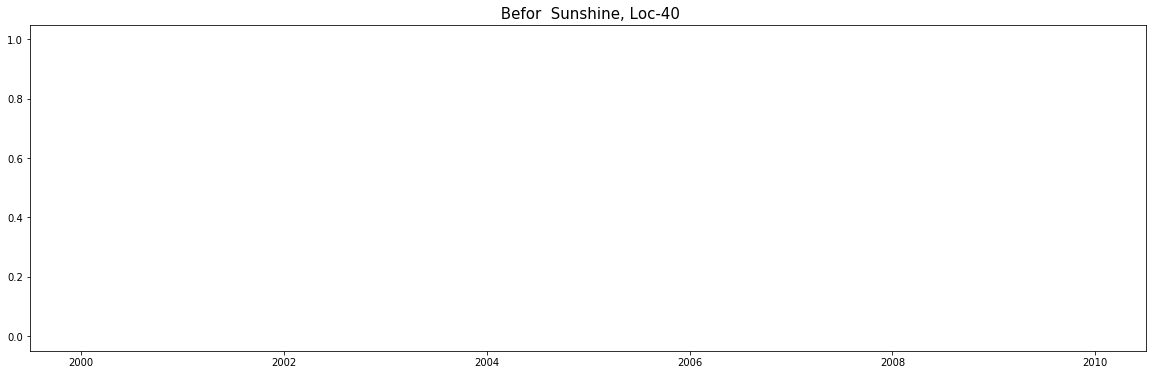

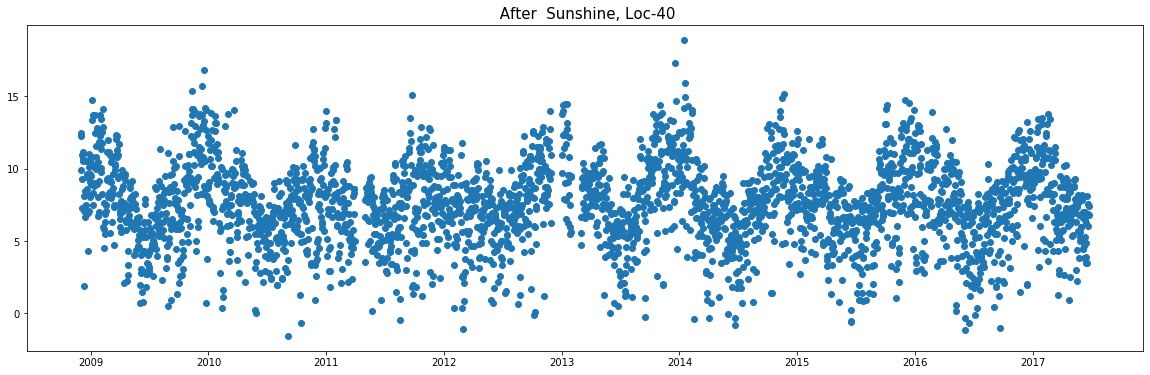

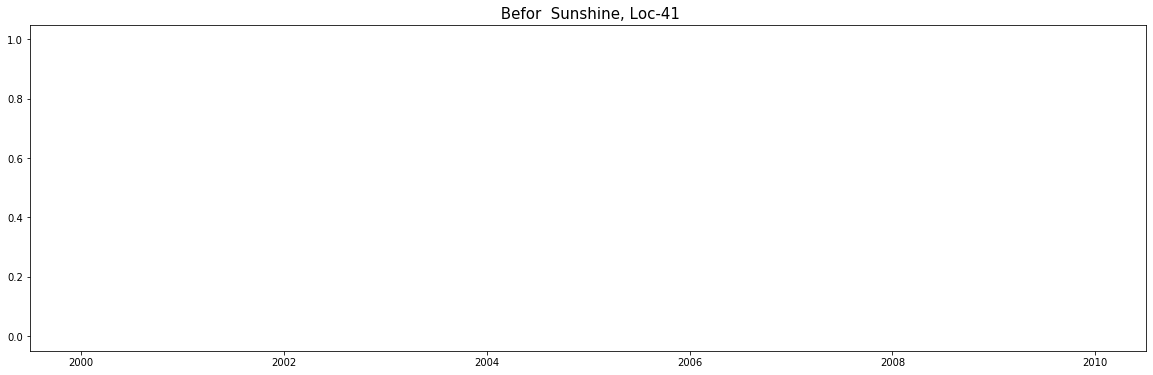

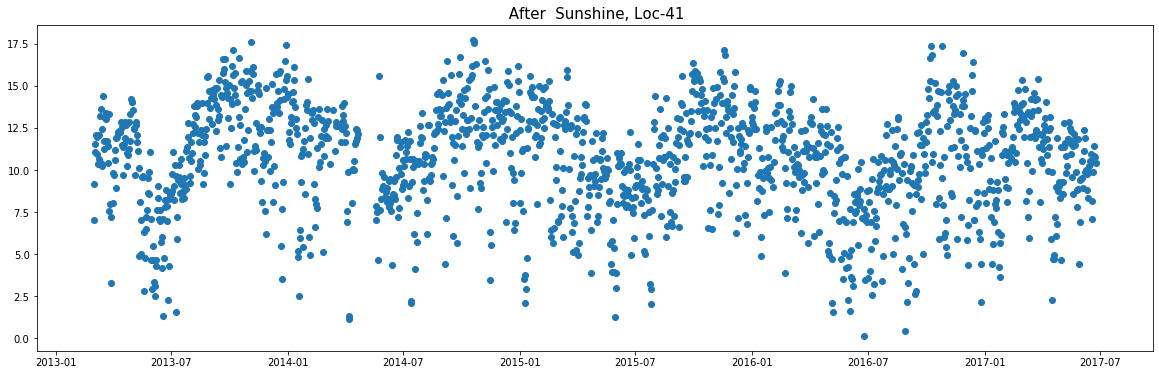

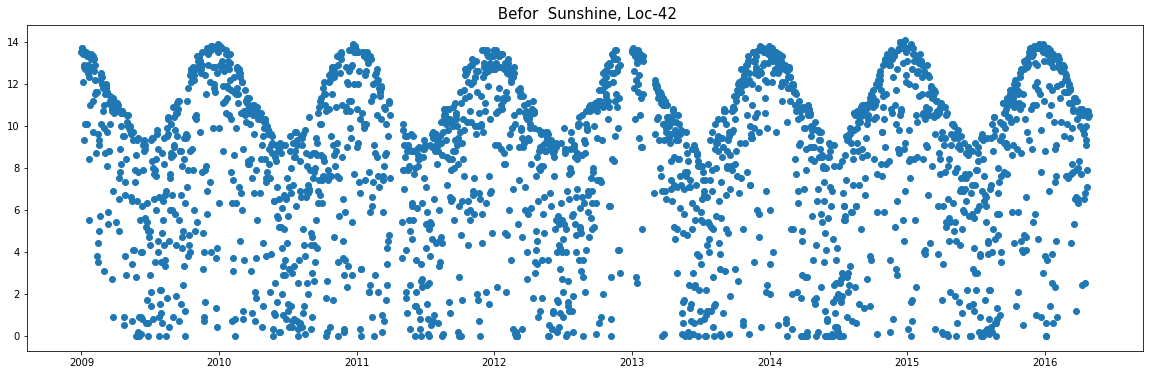

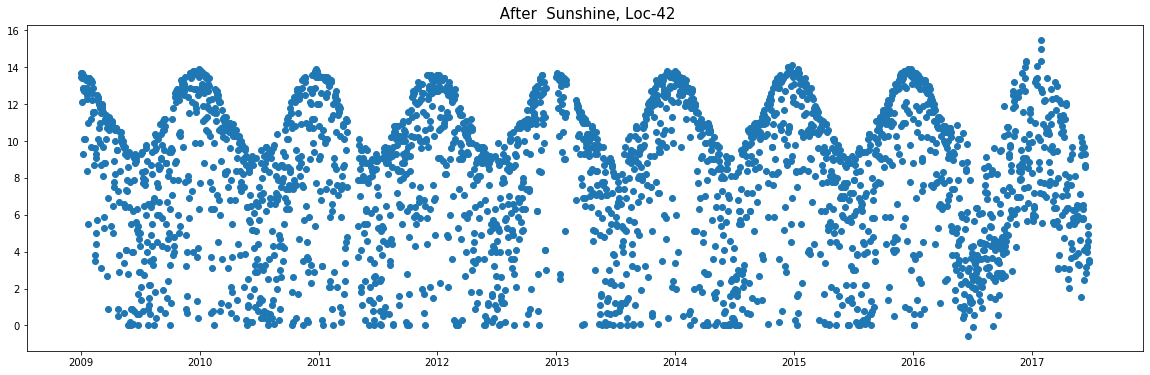

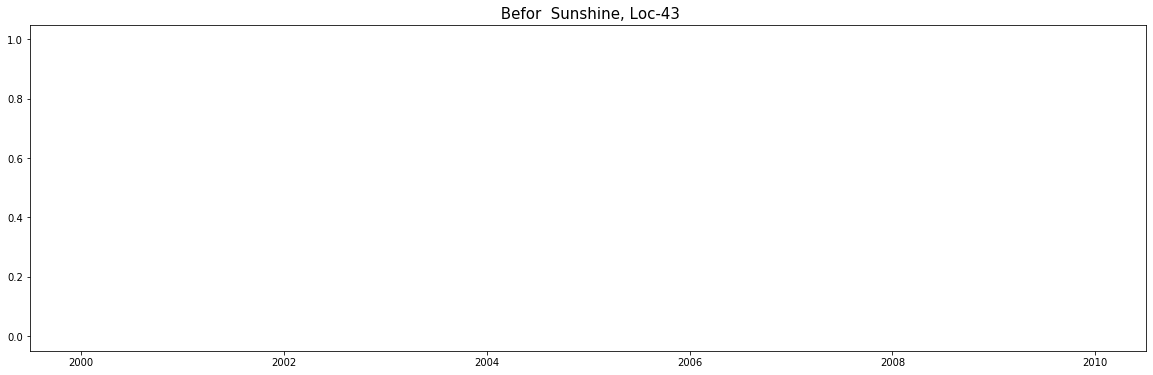

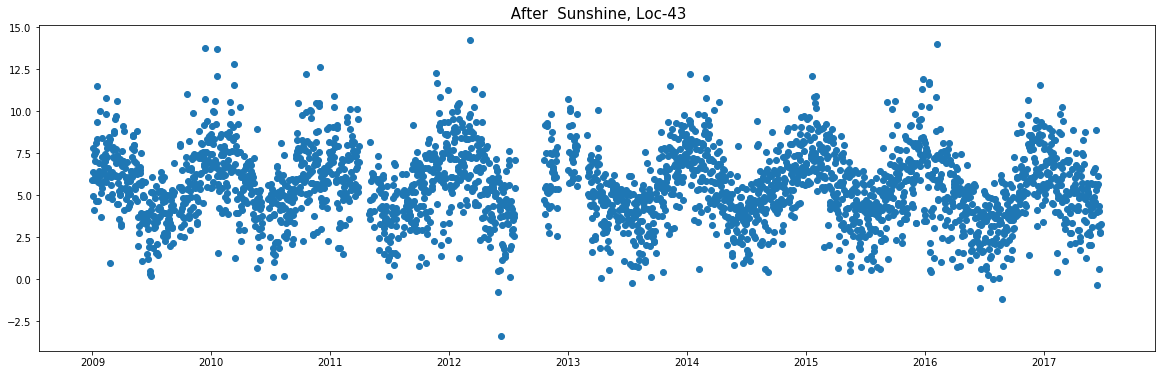

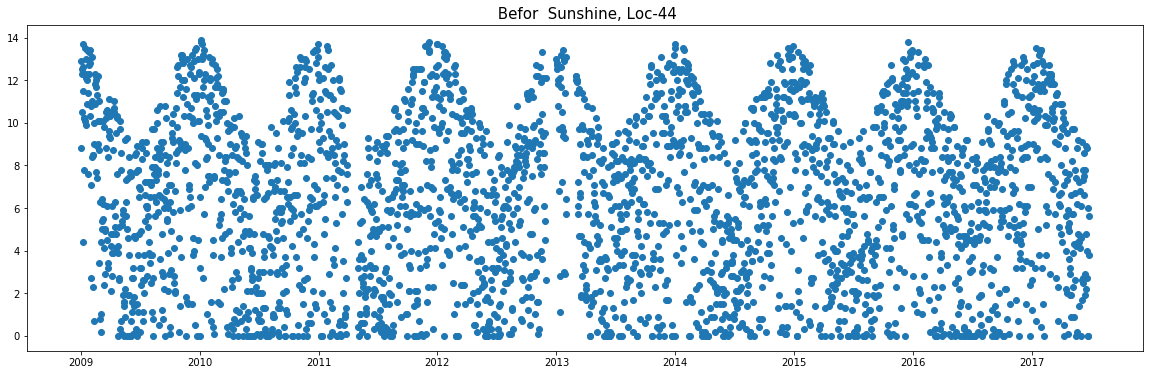

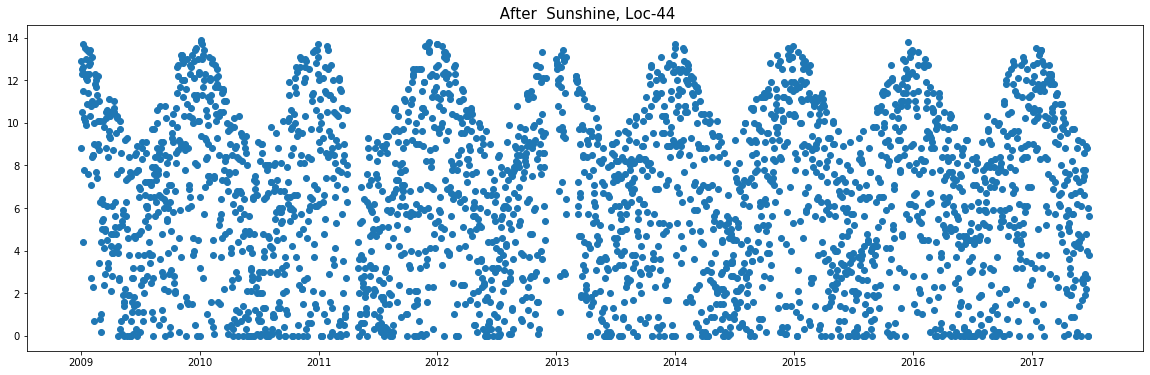

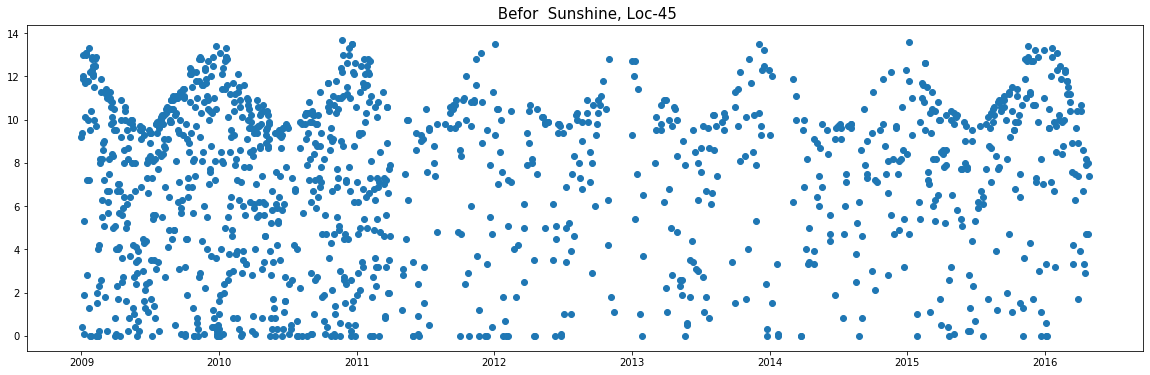

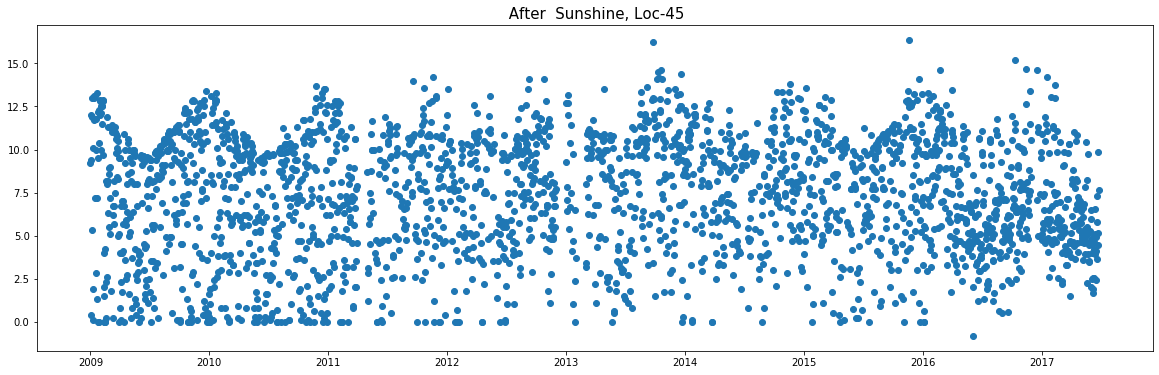

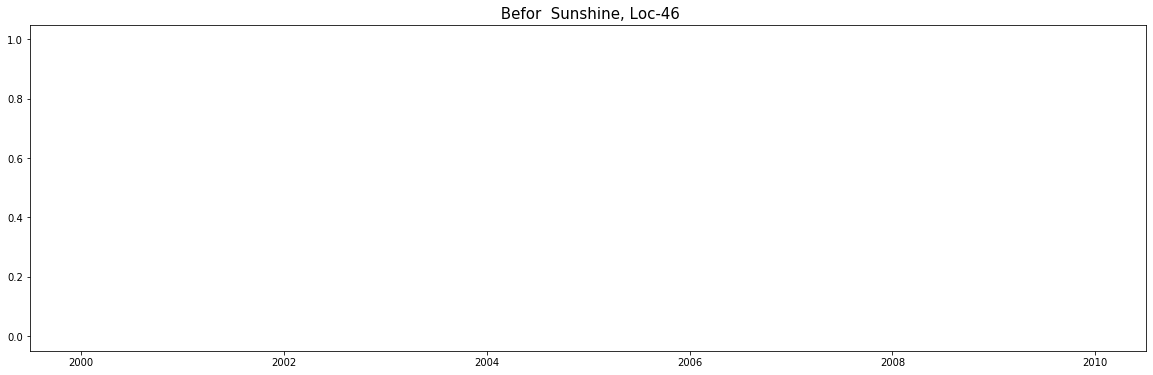

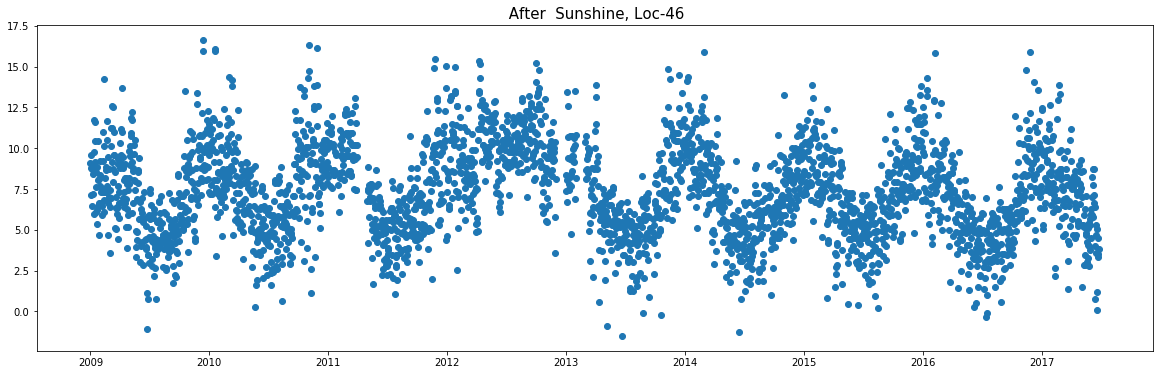

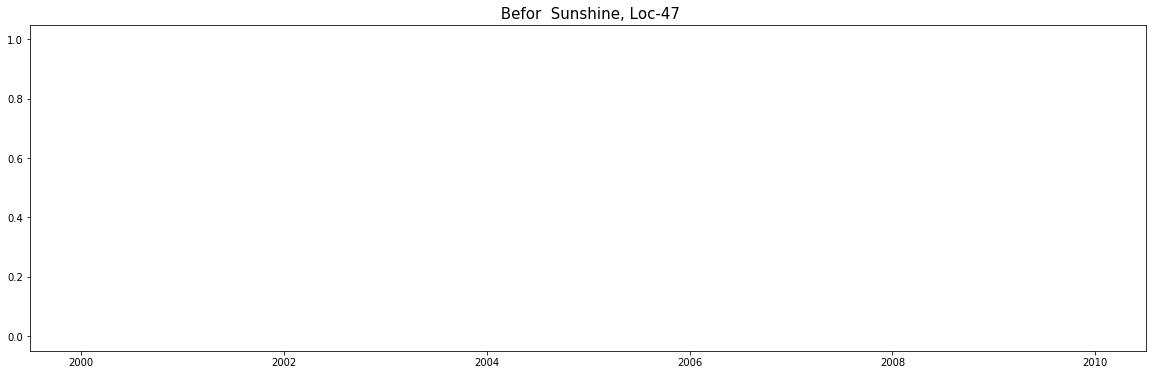

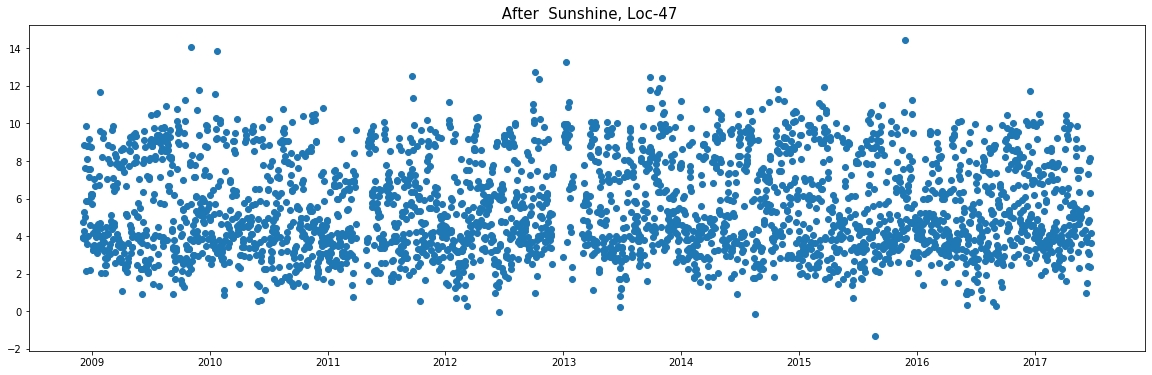

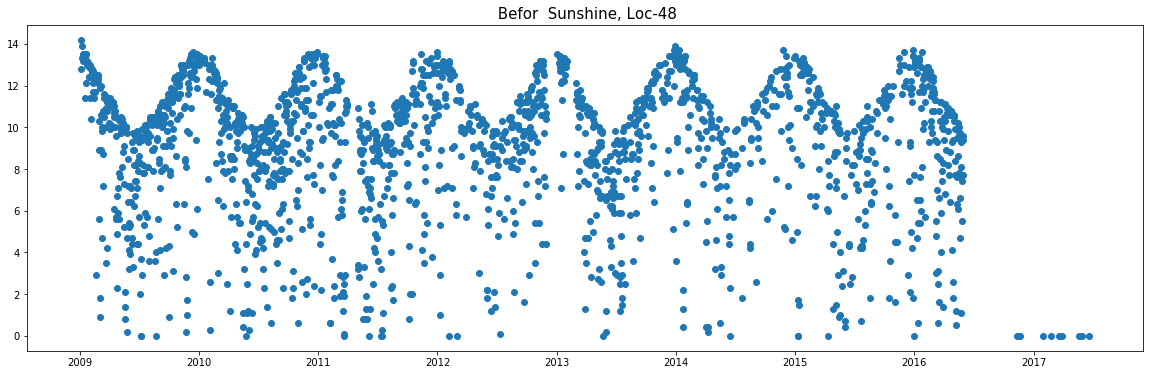

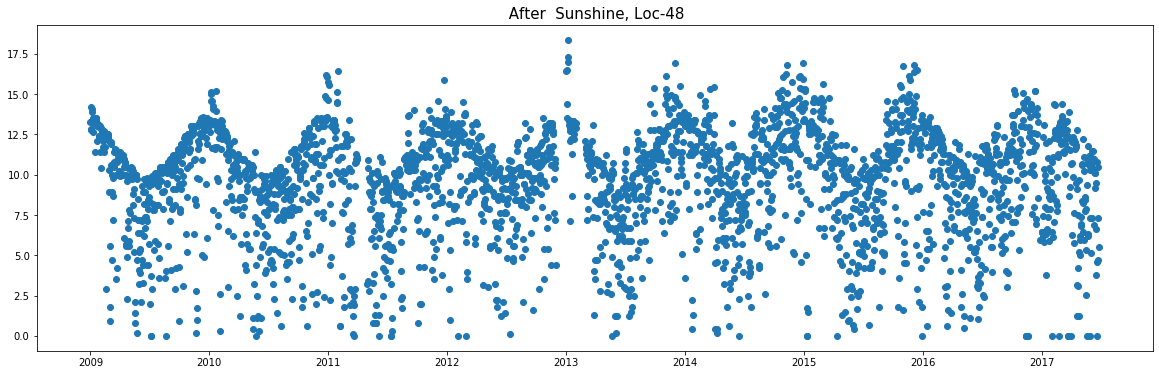

In [142]:
# col_list = ['Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm']
# loc_list = [4, 11] # range(49)
col_list = ['Sunshine']
loc_list = range(49) #[ 10]

# 'Date', 'Location_ID', 'Cloud9am', 'Cloud3pm', 'Humidity9am',
#        'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'MinTemp', 'MaxTemp',
#        'Temp9am', 'Temp3pm', 'Rainfall', 'Evaporation', 'Sunshine',
#        'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
#        'WindSpeed9am', 'WindSpeed3pm', 'year', 'month', 'summer', 'winter',
#        'autumn', 'spring'

def plot_ts(df, location_id, col, prefix=None):
    mask = df['Location_ID'] == location_id
    plt.figure(figsize=(20,6))
    plt.scatter(x=df[mask]['Date'], y=df[mask][col]);
    plt.title(f' {prefix}  {col}, Loc-{location_id}', fontsize=15)

for col in col_list:
    for location_id in loc_list: 
        plot_ts(df_befor, location_id, col, 'Befor')
        plot_ts(df, location_id, col, 'After')

# Plot HeatMap missing values

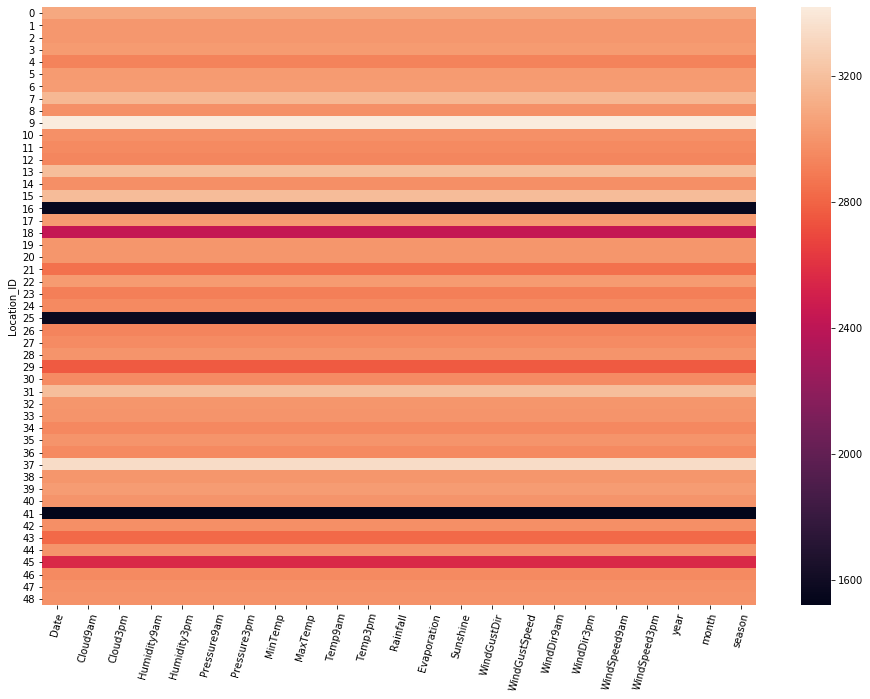

In [140]:
plt.figure(figsize=(16,11))
sns.heatmap(df.groupby(by='Location_ID').count());
plt.xticks(rotation=75);